# Technico-environmental analysis and recommendations for small wind turbine systems

This code was used to generate the results presented in our article ("Finding the Optimal Tower Height for Small Wind Turbine Systems: A Technico-Environmental Approach")[https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4743041] by Prevost et al. 2024.  It is provided in open access under the license ... to allow the scientific community to build up on the methodology and result outcomes of this work. 

In this study investigates the compromise between energy harvest and environmental impacts of a SWT system, taking into account the system design, the site characteristics, and the user behavior aspects. Using the LCA methodology, the impact assessment of the SWT system is compared for several tower heights. Then, the tower is used as a leverage to optimize the environmental footprint of the system functional electricity (i.e. the electricity meeting the user energy need). We show that there exists an optimal tower height that minimizes the environmental footprint of the SWT electricity.

## Setup

At first we import the necessary packages (brightway for LCA, pandas for data, numpy for computations, matplotlib for graphs) and we select the proper project.

In [ ]:

import brightway2 as bw
from brightway2 import *

bw.Database('biosphere3').delete()
bw.Database('biosphere3').deregister()
all_method_tuples = list(bw.methods)
for m in all_method_tuples:
    bw.Method(m).deregister()
bw.bw2setup()

In [1]:
####IMPORTING####

from brightway2 import *
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import mylib


from copy import deepcopy
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from matplotlib.ticker import ScalarFormatter
from mylib import *
from variables import powercurve
from LCIA_setup import *


##PLT settings##
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})
plt.rcParams['font.size'] = 17
projects.set_current('ACV_eol')
n=200 #number of points between 12 and 24 m mast height

## System modelling

The energy production of the wind turbine depends on the caracteristics of the wind turbine itself but also the wind distribution on site. The European standard  EN 61400-12-1 has a standardized method to compute the Annual Energy Production $AEP$ of the wind turbine.
The power curve $P$ of the wind turbine gives us the power generated for values of the wind speed. For the wind distribution on site we use the Rayleigh cumulative probability distribution $F(V)$.

<p style="text-align: center;">$F(V) = 1-e^{-\frac{\pi}{4}\left(\frac{V}{V_{avg}}\right)^2}$</p>

where

$V$ is the wind speed

$V_{avg}$ is the average wind speed at hub height

The $AEP$ is computed using $N$ bins $i$, each containing a wind speed $V_i$ and its associated power $P_i$

<p style="text-align: center;">$AEP = N_h \sum_{i=1}^N[F(V_i)-F(V_{i-1})]\left(\frac{P_{i-1}+P_i}{2}\right)$</p>

$N_h$ is the number of hours in a year.

$V_{avg}$ has to be computed from models and values measured on site. For a given site we can get an average wind speed $V_{ref}$ at a given height $h_{ref}$. There are several models to get the wind speed at given height knowing the wind speed at an other height.

 The power law uses the wind shear exponent $\alpha$ measured empirically on several types terrain, it depends on the roughness of terrain which changes the distrbution of wind at different heights.

<p style="text-align: center;">$V = V_{ref} \left(\frac{h}{h_{ref}}\right)^\alpha$</p>

The logarithmic law uses the surface roughness length $z_0$ which plays a role similar to $\alpha$ but has a dimension homogeneous to a length.

<p style="text-align: center;">$V = V_{ref}\frac{\ln\left(\frac{h}{z_0}\right)}{\ln\left(\frac{h_{ref}}{z_0}\right)}$</p>

[   1.13346218  -33.55609328  317.05658339 -737.61059692  404.18003629]


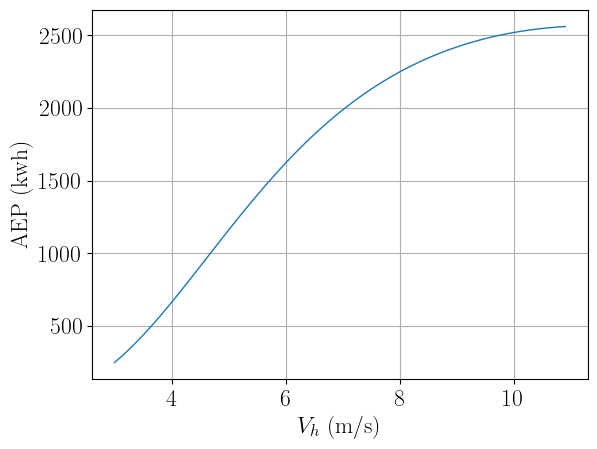

In [2]:
v_mu=np.arange(3,11,0.1)# vector of average wind speed at hub height
aep=np.zeros(len(v_mu))
for i in range(len(v_mu)):
    aep[i]=aep_rayleigh(v_mu[i],powercurve)/1000
aep_poly=np.polyfit(v_mu,aep,4)  
print(aep_poly)
## Plot aep=f(v_mu)
fig, ax = plt.subplots()
ax.set_ylabel('AEP (kwh)')
ax.set_xlabel('$V_h$ (m/s)')
ax.plot(v_mu,aep,linewidth = 1)
#ax.plot(v_mu,np.polyval(aep_poly,v_mu),label='fit')
ax.grid(True)
plt.show()
fig.savefig("figures/aep.svg")

In [3]:
aep_rayleigh(wind_shear_log(4,12,18,0.01),powercurve)/1000

771.98659076875

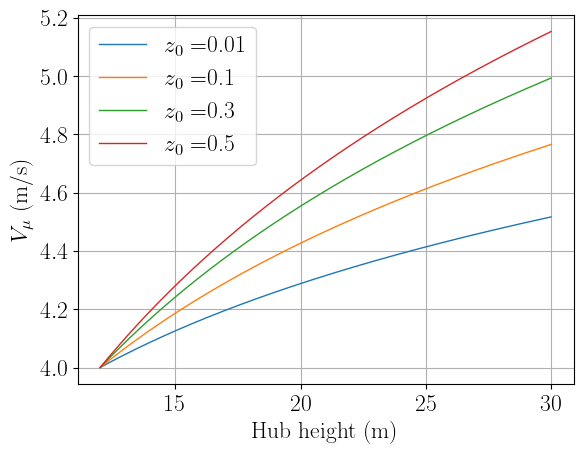

In [4]:
v_ref=4
h_ref=12
h_max=30
h=np.linspace(h_ref,h_max,200)
z_0=np.array([0.01, 0.1,0.3, 0.5])
v=np.ones((len(h),len(z_0)))
aep=np.ones((len(h),len(z_0)))

for i in range(len(h)):
    for j in range(len(z_0)):
        v[i,j]=wind_shear_log(v_ref,h_ref,h[i],z_0[j])
        aep[i,j]=aep_rayleigh(v[i,j],powercurve)/1000

fig, ax = plt.subplots()
ax.set_xlabel('Hub height (m)')
ax.set_ylabel('$V_\mu$ (m/s)')
for j in range(len(z_0)):
    ax.plot(h,v[:,j],label='$z_0=$'+ str(z_0[j]),linewidth = 1)

ax.legend()
ax.grid(True)
plt.show() 


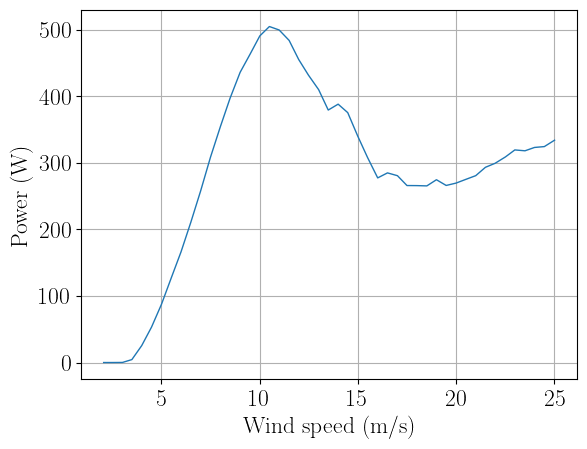

In [5]:
# plot wind turbine power curve
fig, ax = plt.subplots()
ax.set_xlabel('Wind speed (m/s)')
ax.set_ylabel('Power (W)')
ax.plot(powercurve.Vw,powercurve.Pdc,linewidth = 1,label="Standalone DC 48V NTUA")
ax.grid(True)
fig.savefig("figures/powercurve.svg")
plt.show() 

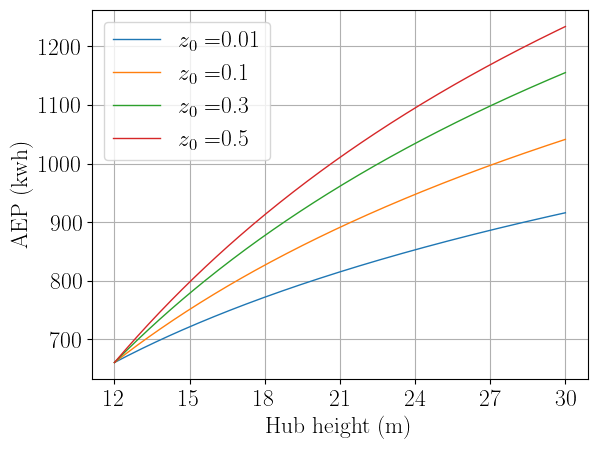

In [6]:
fig, ax = plt.subplots()
ax.set_ylabel('AEP (kwh)')
ax.set_xlabel('Hub height (m)')

for j in range(len(z_0)):
    ax.plot(h,aep[:,j],label='$z_0=$'+ str(z_0[j]),linewidth = 1)

ax.legend()
ax.set_xticks(np.arange(12, 33, 3))
ax.grid(True)
plt.show() 
fig.savefig("figures/aep_z0.svg")


## Battery sizing for first LCA scenario A and B

In [7]:
h_sc=np.linspace(12,18,2)
h_indexes=np.ones(len(h_sc))
z_0_sc=0.5
for i in range(len(h_sc)):
    h_indexes[i] = int(np.abs(h - h_sc[i]).argmin())
z_0_indexes = np.abs(z_0 - z_0_sc).argmin()


In [8]:
## off-grid
lep_sc=20*np.array([aep[int(h_indexes[0]),int(z_0_indexes)],aep[int(h_indexes[1]),int(z_0_indexes)]])
dep_sc=lep_sc/365/20
inverter_efficiency=0.9
battery_efficiency=0.8
oversizing_factor=0.15 # Average proportion of energy being lost in dump load
N_d=2 # Number of days of autonomy
SoC_min=0.5 # Minimum acceptable battery SoC
system_lifetime=20
load_shifting_factor=0.2

#lifetime useful energy
lue_sc=lep_sc*(1-oversizing_factor)*inverter_efficiency*(load_shifting_factor+(1-load_shifting_factor)*battery_efficiency)
print('LEP',lep_sc)
print('LUE',lue_sc)
#daily energy needs (DEN)
den_kwh=lue_sc/365/20
print ('DEN',den_kwh)

LEP [13208.43596155 18234.49865898]
LUE [ 8487.74094889 11717.48883826]
DEN [1.16270424 1.60513546]


In [9]:
## grid tied

E_g=(1-load_shifting_factor)*dep_sc*inverter_efficiency # daily withdrawn grid energy
den_grid=dep_sc*inverter_efficiency
lue_grid=den_grid*365*20
leg=E_g*365*20 # lifetime grid energy

In [10]:
leg

array([ 9510.07389231, 13128.83903446])

In [11]:
# Battery sizing

bat_cap_kwh=(1-load_shifting_factor)*den_kwh*N_d/SoC_min
bat_cap_kwh

array([3.72065357, 5.13643346])

In [12]:
bat_specific_energy=30.58 # Kebede et al. 2021
kg_kwh=1000/bat_specific_energy # wh/kg to kg/kwh
bat_fit=np.array([kg_kwh, 0])
bat_weight_kg=kg_kwh*bat_cap_kwh
bat_weight_kg

array([121.66950839, 167.96708513])

In [13]:
print(h_sc[0],'m tower -','Average wind speed at hub height',v[int(h_indexes[0]),int(z_0_indexes)],': Daily Energy Needs (kwh) : ',den_kwh[0],' Battery capacity (kwh) : ',bat_cap_kwh[0], ' Battery weight (kg) : ',bat_weight_kg[0])

print(h_sc[1],'m tower -','Average wind speed at hub height',v[int(h_indexes[1]),int(z_0_indexes)],': Daily Energy Needs (kwh) : ',den_kwh[1],' Battery capacity (kwh) : ',bat_cap_kwh[1], ' Battery weight (kg) : ',bat_weight_kg[1])


12.0 m tower - Average wind speed at hub height 4.0 : Daily Energy Needs (kwh) :  1.1627042395739715  Battery capacity (kwh) :  3.720653566636709  Battery weight (kg) :  121.66950839230573
18.0 m tower - Average wind speed at hub height 4.50822129936887 : Daily Energy Needs (kwh) :  1.6051354572955847  Battery capacity (kwh) :  5.136433463345871  Battery weight (kg) :  167.9670851323045


# LCA of complete wind turbine

In [14]:
####SET LCIA METHODS####

from LCIA_setup import *

activities_wt=[Database('12m_wind_turbine').search(j)[0] for (i,j) in order_wt.items()]
activities_18m=[Database('18m_mast').search(j)[0] for (i,j) in order_18m.items()]
activities_12m=[Database('12m_mast').search(j)[0] for (i,j) in order_12m.items()]
activities_electronics = [Database('electronics_wind_turbine_oswacc').search(j)[0] for (i,j) in order_electronics.items()]
activities_electronics_grid = [Database('electronics_wind_turbine_oswacc').search(j)[0] for (i,j) in order_electronics_grid.items()]

#### This step requires extra carefulness, here 'order_18' and 'activities_18' contain activities from the mast, turbine and electronics
#### so the lcia using these variables will take into account impacts from mast turbine and electronics
### for 12 m lcia, change 18 to 12


# Off-grid

## For a 18 m mast

In [15]:
# Scale battery for 18 m energy yield

act_batteries=activities_electronics[3]# activites are concatenated
batteries_key = Database('electronics_wind_turbine_oswacc').search('market for battery, lead acid, rechargeable, stationary', filter={'location':'GLO'})[0].key
batteries_exc = [i for i in act_batteries.exchanges() if i['input'] == batteries_key][0]

batteries_exc.as_dict()['amount'] =  bat_weight_kg[1] 
batteries_exc.save()

activities_18=activities_wt+activities_18m+activities_electronics
order_18 = order_wt | order_18m | order_electronics

activities_18

Excluding 0 filtered results


['production of wind turbine wood only' (unit, GLO, None),
 'production of wind turbine steel only' (unit, GLO, None),
 'production of wind turbine resin only' (unit, GLO, None),
 'production of wind turbine magnet only' (unit, GLO, None),
 'production of wind turbine copper only' (unit, GLO, None),
 'production of wind turbine other materials only' (unit, GLO, None),
 'transport of wind turbine' (unit, GLO, None),
 'production of 18m structure steel no zinc' (unit, GLO, None),
 'production of 18m structure concrete only' (unit, GLO, None),
 'production of 18m zinc coat' (unit, GLO, None),
 'production of mast cable 48V' (unit, GLO, None),
 'transport of 18m concrete structure' (unit, GLO, None),
 'transport of 18m steel structure' (unit, GLO, None),
 'rectifier final' (unit, GLO, None),
 'charge controller final' (unit, GLO, None),
 'dump load final' (unit, GLO, None),
 'batteries final' (unit, GLO, None),
 'inverter final' (unit, GLO, None),
 'cable final' (unit, GLO, None),
 'transp

In [16]:
batteries_exc

Exchange: 167.9670851323045 kilogram 'market for battery, lead acid, rechargeable, stationary' (kilogram, GLO, None) to 'batteries final' (unit, GLO, None)>

In [17]:
####COMPUTE LCIA RESULTS FOR ALL METHODS####
score={}
for i in range(len(order_18)): #Cycle through activities
    array_score=np.zeros(len(methods_EF)) #Results are in a np array
    for j in range(len(methods_EF)): # Cycle through methods
        lca = LCA(demand={activities_18[i]:1},
                 method=methods_EF[j])
        lca.lci()
        lca.lcia()
        #score.append(lca.score)
        array_score[j]=lca.score #store result
    score[list(order_18.keys())[i]]=array_score # Store the np.array in the score dictionary for easier handling 



In [18]:
store_score_18 = pd.DataFrame.from_dict(score,orient='index')
store_score_18
store_score_18.to_csv("lca_12_18/score_18_full_impacts.csv")

In [19]:
contributions_18={}

for i in range(len(order_18)):
    contributions_18[list(score.keys())[i]]=EF_single_score(score[list(score.keys())[i]],NF,WF)
contributions_18_df=pd.DataFrame.from_dict(contributions_18,orient='index')
contributions_18_df.to_csv("lca_12_18/contributions_18.csv",decimal=",")

In [20]:
# compute EF 3.0 single score
score_18=np.zeros((len(methods_EF),2))
for i in range(len(methods_EF)): # iterate in categories
   score_18[i,0]=i
   score_18[i,1]=np.sum(store_score_18[i])  # sum of scores for all activities 
score_18

array([[0.00000000e+00, 3.66583545e+01],
       [1.00000000e+00, 2.92702299e+03],
       [2.00000000e+00, 2.44255946e+05],
       [3.00000000e+00, 3.40989440e+04],
       [4.00000000e+00, 2.03999633e+00],
       [5.00000000e+00, 5.82675122e+00],
       [6.00000000e+00, 7.94017047e+01],
       [7.00000000e+00, 1.18391500e-05],
       [8.00000000e+00, 4.27320844e-04],
       [9.00000000e+00, 2.69665044e+02],
       [1.00000000e+01, 3.24380771e+04],
       [1.10000000e+01, 6.57017780e-01],
       [1.20000000e+01, 2.29677811e-04],
       [1.30000000e+01, 2.88491990e-04],
       [1.40000000e+01, 1.27198515e+01],
       [1.50000000e+01, 1.39782097e+03]])

In [21]:
single_score=EF_single_score(score_18[:,1],NF,WF)
scorenorm=np.column_stack((score_18,score_18[:,1]/NF*WF))
scorenorm

array([[0.00000000e+00, 3.66583545e+01, 4.08780212e-02],
       [1.00000000e+00, 2.92702299e+03, 7.61025978e-02],
       [2.00000000e+00, 2.44255946e+05, 1.09829372e-01],
       [3.00000000e+00, 3.40989440e+04, 4.36466484e-02],
       [4.00000000e+00, 2.03999633e+00, 3.54781971e-02],
       [5.00000000e+00, 5.82675122e+00, 8.84470954e-03],
       [6.00000000e+00, 7.94017047e+01, 1.66429562e-02],
       [7.00000000e+00, 1.18391500e-05, 1.49215322e-02],
       [8.00000000e+00, 4.27320844e-04, 3.41856675e-02],
       [9.00000000e+00, 2.69665044e+02, 3.20147363e-03],
       [1.00000000e+01, 3.24380771e+04, 3.14479038e-03],
       [1.10000000e+01, 6.57017780e-01, 7.79950352e-01],
       [1.20000000e+01, 2.29677811e-04, 2.70385632e-04],
       [1.30000000e+01, 2.88491990e-04, 4.34434996e-02],
       [1.40000000e+01, 1.27198515e+01, 1.49755887e-02],
       [1.50000000e+01, 1.39782097e+03, 1.03438752e-02]])

In [22]:
scorenorm=np.column_stack((scorenorm,scorenorm[:,2]/single_score))
scorenorm

array([[0.00000000e+00, 3.66583545e+01, 4.08780212e-02, 3.30765882e-02],
       [1.00000000e+00, 2.92702299e+03, 7.61025978e-02, 6.15786726e-02],
       [2.00000000e+00, 2.44255946e+05, 1.09829372e-01, 8.88688048e-02],
       [3.00000000e+00, 3.40989440e+04, 4.36466484e-02, 3.53168321e-02],
       [4.00000000e+00, 2.03999633e+00, 3.54781971e-02, 2.87073023e-02],
       [5.00000000e+00, 5.82675122e+00, 8.84470954e-03, 7.15672643e-03],
       [6.00000000e+00, 7.94017047e+01, 1.66429562e-02, 1.34667039e-02],
       [7.00000000e+00, 1.18391500e-05, 1.49215322e-02, 1.20738079e-02],
       [8.00000000e+00, 4.27320844e-04, 3.41856675e-02, 2.76614477e-02],
       [9.00000000e+00, 2.69665044e+02, 3.20147363e-03, 2.59048314e-03],
       [1.00000000e+01, 3.24380771e+04, 3.14479038e-03, 2.54461770e-03],
       [1.10000000e+01, 6.57017780e-01, 7.79950352e-01, 6.31099447e-01],
       [1.20000000e+01, 2.29677811e-04, 2.70385632e-04, 2.18783442e-04],
       [1.30000000e+01, 2.88491990e-04, 4.34434996e

In [23]:
scorenorm_df=pd.DataFrame(scorenorm,columns=['Category number', 'Raw score', 'Normalized_Weighted', 'Score_ratio'])


In [24]:
I=np.argsort(-scorenorm_df.Score_ratio) #sort descending
score_sort=scorenorm[I,:]


In [25]:
score_sort=np.column_stack((score_sort,np.zeros(len(methods_EF))))
sum_ratio=0
methods_80=[]
m=0
for i in range(len(methods_EF)):
    sum_ratio+=score_sort[i,3]
    score_sort[i,4]=sum_ratio
    if sum_ratio<0.8:
        m+=1
for i in range(m):
    methods_80.append(methods_EF[int(score_sort[i,0])][1])
print('The methods cumulating at least 80% of impacts are',methods_80)


The methods cumulating at least 80% of impacts are ['material resources: metals/minerals', 'ecotoxicity: freshwater', 'climate change']


In [26]:
score_sort_df=pd.DataFrame(score_sort,columns=['Category_number', 'Raw score', 'Normalized_Weighted', 'Score_ratio', 'Cumulative'])
print(score_sort_df)

    Category_number      Raw score  Normalized_Weighted  Score_ratio  \
0              11.0       0.657018             0.779950     0.631099   
1               2.0  244255.946044             0.109829     0.088869   
2               1.0    2927.022992             0.076103     0.061579   
3               3.0   34098.944050             0.043647     0.035317   
4              13.0       0.000288             0.043443     0.035152   
5               0.0      36.658355             0.040878     0.033077   
6               4.0       2.039996             0.035478     0.028707   
7               8.0       0.000427             0.034186     0.027661   
8               6.0      79.401705             0.016643     0.013467   
9              14.0      12.719852             0.014976     0.012118   
10              7.0       0.000012             0.014922     0.012074   
11             15.0    1397.820966             0.010344     0.008370   
12              5.0       5.826751             0.008845     0.00

In [27]:
for i in range(len(I)):
    score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]
print(score_sort_df)
score_sort_df.to_csv("lca_12_18/score_18_methods_choice.csv",decimal=",")

                                Category_number      Raw score  \
0           material resources: metals/minerals       0.657018   
1                       ecotoxicity: freshwater  244255.946044   
2                                climate change    2927.022992   
3               energy resources: non-renewable   34098.944050   
4                  particulate matter formation       0.000288   
5                                 acidification      36.658355   
6                    eutrophication: freshwater       2.039996   
7              human toxicity: non-carcinogenic       0.000427   
8                   eutrophication: terrestrial      79.401705   
9   photochemical ozone formation: human health      12.719852   
10                 human toxicity: carcinogenic       0.000012   
11                                    water use    1397.820966   
12                       eutrophication: marine       5.826751   
13             ionising radiation: human health     269.665044   
14        

/tmp/ipykernel_5315/1848194607.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'material resources: metals/minerals' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]


In [28]:
####Select LCIA RESULTS FOR MOST RELEVANT METHODS####

categories_shortlist=5
store_score_18_rec=store_score_18[I[0:categories_shortlist]]

In [29]:

store_score_18_rec.to_csv("lca_12_18/score_18_V2.csv")

store_score_18_rec

,11,2,1,3,13
wood,0.000223,955.401997,23.647301,503.078317,4.544212e-06
steel,0.002670,3885.668682,109.014878,1192.274770,7.905063e-06
resin,0.000115,317.317040,9.791659,222.464715,4.207375e-07
magnet,0.002540,10699.940429,84.274904,920.306774,7.821993e-06
copper,0.042005,15894.202583,38.258497,556.169076,4.572323e-06
other,0.003675,1357.488502,7.095496,113.254149,7.873071e-07
transport,0.000011,40.504873,3.325971,48.476418,3.078201e-07
18m steel no zinc,0.003454,20314.440381,741.831310,7461.142387,4.871560e-05
18m concrete,0.005701,9707.523209,556.245056,4115.119432,2.620715e-05
18m zinc,0.031257,17432.865991,98.757743,1619.171042,9.080428e-05


## For 12m mast

In [30]:
# scale battery for energy needs
batteries_exc.as_dict()['amount'] =  bat_weight_kg[0]
batteries_exc.save()


activities_12=activities_wt+activities_12m+activities_electronics
order_12 = order_wt | order_12m | order_electronics

activities_12

['production of wind turbine wood only' (unit, GLO, None),
 'production of wind turbine steel only' (unit, GLO, None),
 'production of wind turbine resin only' (unit, GLO, None),
 'production of wind turbine magnet only' (unit, GLO, None),
 'production of wind turbine copper only' (unit, GLO, None),
 'production of wind turbine other materials only' (unit, GLO, None),
 'transport of wind turbine' (unit, GLO, None),
 'production of 12m structure steel no zinc' (unit, GLO, None),
 'production of 12m structure concrete only' (unit, GLO, None),
 'production of 12m zinc coat' (unit, GLO, None),
 'production of mast cable 48V' (unit, GLO, None),
 'transport of 12m concrete structure' (unit, GLO, None),
 'transport of 12m steel structure' (unit, GLO, None),
 'rectifier final' (unit, GLO, None),
 'charge controller final' (unit, GLO, None),
 'dump load final' (unit, GLO, None),
 'batteries final' (unit, GLO, None),
 'inverter final' (unit, GLO, None),
 'cable final' (unit, GLO, None),
 'transp

In [31]:
score={}
for i in range(len(order_12)): #Cycle through activities
    array_score=np.zeros(len(methods_EF)) #Results are in a np array
    for j in range(len(methods_EF)): # Cycle through methods
        lca = LCA(demand={activities_12[i]:1},
                 method=methods_EF[j])
        lca.lci()
        lca.lcia()
        #score.append(lca.score)
        array_score[j]=lca.score #store result
    score[list(order_12.keys())[i]]=array_score # Store the np.array in the score dictionary for easier handling 



In [32]:
store_score_12 = pd.DataFrame.from_dict(score,orient='index')
store_score_12
store_score_12.to_csv("lca_12_18/score_12_full_impacts_v2.csv")

In [33]:
contributions_12={}
for i in range(len(order_12)):
    contributions_12[list(score.keys())[i]]=EF_single_score(score[list(score.keys())[i]],NF,WF)
contributions_12_df=pd.DataFrame.from_dict(contributions_12,orient='index')
contributions_12_df.to_csv("lca_12_18/contributions_12_V2.csv",decimal=",")

In [34]:
# compute EF 3.0 single score
score_12=np.zeros((len(methods_EF),2))
for i in range(len(methods_EF)):
   score_12[i,0]=i
   score_12[i,1]=np.sum(store_score_12[i])  
score_12

array([[0.00000000e+00, 2.72118055e+01],
       [1.00000000e+00, 2.28613865e+03],
       [2.00000000e+00, 1.95021926e+05],
       [3.00000000e+00, 2.63271365e+04],
       [4.00000000e+00, 1.62175237e+00],
       [5.00000000e+00, 4.99554082e+00],
       [6.00000000e+00, 5.32042630e+01],
       [7.00000000e+00, 8.62723157e-06],
       [8.00000000e+00, 3.31387704e-04],
       [9.00000000e+00, 2.16290956e+02],
       [1.00000000e+01, 2.91559121e+04],
       [1.10000000e+01, 5.18553655e-01],
       [1.20000000e+01, 1.82714448e-04],
       [1.30000000e+01, 2.04536186e-04],
       [1.40000000e+01, 1.00007010e+01],
       [1.50000000e+01, 1.03472886e+03]])

In [35]:
single_score=EF_single_score(score_12[:,1],NF,WF)
scorenorm=np.column_stack((score_12,score_12[:,1]/NF*WF))
scorenorm

array([[0.00000000e+00, 2.72118055e+01, 3.03440997e-02],
       [1.00000000e+00, 2.28613865e+03, 5.94396050e-02],
       [2.00000000e+00, 1.95021926e+05, 8.76913579e-02],
       [3.00000000e+00, 2.63271365e+04, 3.36987347e-02],
       [4.00000000e+00, 1.62175237e+00, 2.82043890e-02],
       [5.00000000e+00, 4.99554082e+00, 7.58297478e-03],
       [6.00000000e+00, 5.32042630e+01, 1.11518540e-02],
       [7.00000000e+00, 8.62723157e-06, 1.08733747e-02],
       [8.00000000e+00, 3.31387704e-04, 2.65110163e-02],
       [9.00000000e+00, 2.16290956e+02, 2.56781443e-03],
       [1.00000000e+01, 2.91559121e+04, 2.82659270e-03],
       [1.10000000e+01, 5.18553655e-01, 6.15578632e-01],
       [1.20000000e+01, 1.82714448e-04, 2.15098538e-04],
       [1.30000000e+01, 2.04536186e-04, 3.08007434e-02],
       [1.40000000e+01, 1.00007010e+01, 1.17742244e-02],
       [1.50000000e+01, 1.03472886e+03, 7.65699357e-03]])

In [36]:
scorenorm=np.column_stack((scorenorm,scorenorm[:,2]/single_score))
scorenorm

array([[0.00000000e+00, 2.72118055e+01, 3.03440997e-02, 3.13823046e-02],
       [1.00000000e+00, 2.28613865e+03, 5.94396050e-02, 6.14732950e-02],
       [2.00000000e+00, 1.95021926e+05, 8.76913579e-02, 9.06916645e-02],
       [3.00000000e+00, 2.63271365e+04, 3.36987347e-02, 3.48517164e-02],
       [4.00000000e+00, 1.62175237e+00, 2.82043890e-02, 2.91693850e-02],
       [5.00000000e+00, 4.99554082e+00, 7.58297478e-03, 7.84242166e-03],
       [6.00000000e+00, 5.32042630e+01, 1.11518540e-02, 1.15334079e-02],
       [7.00000000e+00, 8.62723157e-06, 1.08733747e-02, 1.12454006e-02],
       [8.00000000e+00, 3.31387704e-04, 2.65110163e-02, 2.74180746e-02],
       [9.00000000e+00, 2.16290956e+02, 2.56781443e-03, 2.65567064e-03],
       [1.00000000e+01, 2.91559121e+04, 2.82659270e-03, 2.92330286e-03],
       [1.10000000e+01, 5.18553655e-01, 6.15578632e-01, 6.36640281e-01],
       [1.20000000e+01, 1.82714448e-04, 2.15098538e-04, 2.22458004e-04],
       [1.30000000e+01, 2.04536186e-04, 3.08007434e

In [37]:
scorenorm_df=pd.DataFrame(scorenorm,columns=['Category number', 'Raw score', 'Normalized_Weighted', 'Score_ratio'])


In [38]:
I=np.argsort(-scorenorm_df.Score_ratio) #sort descending
score_sort=scorenorm[I,:]


In [39]:
score_sort=np.column_stack((score_sort,np.zeros(len(methods_EF))))
sum_ratio=0
methods_80=[]
m=1
for i in range(len(methods_EF)):
    sum_ratio+=score_sort[i,3]
    score_sort[i,4]=sum_ratio
    if sum_ratio<0.8:
        m+=1
for i in range(m):
    methods_80.append(methods_EF[int(score_sort[i,0])][1])

print('The methods cumulating at least 80% of impacts are',methods_80)


The methods cumulating at least 80% of impacts are ['material resources: metals/minerals', 'ecotoxicity: freshwater', 'climate change', 'energy resources: non-renewable']


In [40]:
score_sort_df=pd.DataFrame(score_sort,columns=['Category_number', 'Raw score', 'Normalized_Weighted', 'Score_ratio', 'Cumulative'])


In [41]:
for i in range(len(I)):
    score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]
print(score_sort_df)
score_sort_df.to_csv("lca_12_18/score_12_methods_choice_V2.csv",decimal=",")

                                Category_number      Raw score  \
0           material resources: metals/minerals       0.518554   
1                       ecotoxicity: freshwater  195021.926239   
2                                climate change    2286.138655   
3               energy resources: non-renewable   26327.136460   
4                  particulate matter formation       0.000205   
5                                 acidification      27.211806   
6                    eutrophication: freshwater       1.621752   
7              human toxicity: non-carcinogenic       0.000331   
8   photochemical ozone formation: human health      10.000701   
9                   eutrophication: terrestrial      53.204263   
10                 human toxicity: carcinogenic       0.000009   
11                                    water use    1034.728861   
12                       eutrophication: marine       4.995541   
13                                     land use   29155.912147   
14        

/tmp/ipykernel_5315/404374099.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'material resources: metals/minerals' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]


In [42]:
range(categories_shortlist)

range(0, 5)

In [43]:
####Select LCIA RESULTS FOR MOST RELEVANT METHODS####
categories_shortlist=5
store_score_12_rec=store_score_12[I[0:categories_shortlist]]
store_score_12_rec.to_csv("lca_12_18/score_12_V2.csv")

In [44]:
store_score_12_rec

,11,2,1,3,13
wood,0.000223,955.401997,23.647301,503.078317,4.544212e-06
steel,0.002670,3885.668682,109.014878,1192.274770,7.905063e-06
resin,0.000115,317.317040,9.791659,222.464715,4.207375e-07
magnet,0.002540,10699.940429,84.274904,920.306774,7.821993e-06
copper,0.042005,15894.202583,38.258497,556.169076,4.572323e-06
other,0.003675,1357.488502,7.095496,113.254149,7.873071e-07
transport,0.000011,40.504873,3.325971,48.476418,3.078201e-07
12m steel no zinc,0.001952,11329.267859,411.424677,4138.454523,2.740791e-05
12m concrete,0.005701,9707.523209,556.245056,4115.119432,2.620715e-05
12m zinc,0.016912,9429.620773,53.367020,872.410728,4.809426e-05


In [45]:
score_12=pd.read_csv("lca_12_18/score_12_V2.csv",index_col='Unnamed: 0')
score_12

,11,2,1,3,13
wood,0.000223,955.401997,23.647301,503.078317,4.544212e-06
steel,0.002670,3885.668682,109.014878,1192.274770,7.905063e-06
resin,0.000115,317.317040,9.791659,222.464715,4.207375e-07
magnet,0.002540,10699.940429,84.274904,920.306774,7.821993e-06
copper,0.042005,15894.202583,38.258497,556.169076,4.572323e-06
other,0.003675,1357.488502,7.095496,113.254149,7.873071e-07
transport,0.000011,40.504873,3.325971,48.476418,3.078201e-07
12m steel no zinc,0.001952,11329.267859,411.424677,4138.454523,2.740791e-05
12m concrete,0.005701,9707.523209,556.245056,4115.119432,2.620715e-05
12m zinc,0.016912,9429.620773,53.367020,872.410728,4.809426e-05


In [46]:
score_18=pd.read_csv("lca_12_18/score_18_V2.csv",index_col='Unnamed: 0')
score_18

,11,2,1,3,13
wood,0.000223,955.401997,23.647301,503.078317,4.544212e-06
steel,0.002670,3885.668682,109.014878,1192.274770,7.905063e-06
resin,0.000115,317.317040,9.791659,222.464715,4.207375e-07
magnet,0.002540,10699.940429,84.274904,920.306774,7.821993e-06
copper,0.042005,15894.202583,38.258497,556.169076,4.572323e-06
other,0.003675,1357.488502,7.095496,113.254149,7.873071e-07
transport,0.000011,40.504873,3.325971,48.476418,3.078201e-07
18m steel no zinc,0.003454,20314.440381,741.831310,7461.142387,4.871560e-05
18m concrete,0.005701,9707.523209,556.245056,4115.119432,2.620715e-05
18m zinc,0.031257,17432.865991,98.757743,1619.171042,9.080428e-05


/tmp/ipykernel_5315/1428708832.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  impact_12=impacts_12[n]
/tmp/ipykernel_5315/1428708832.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  impact_18=impacts_18[n]


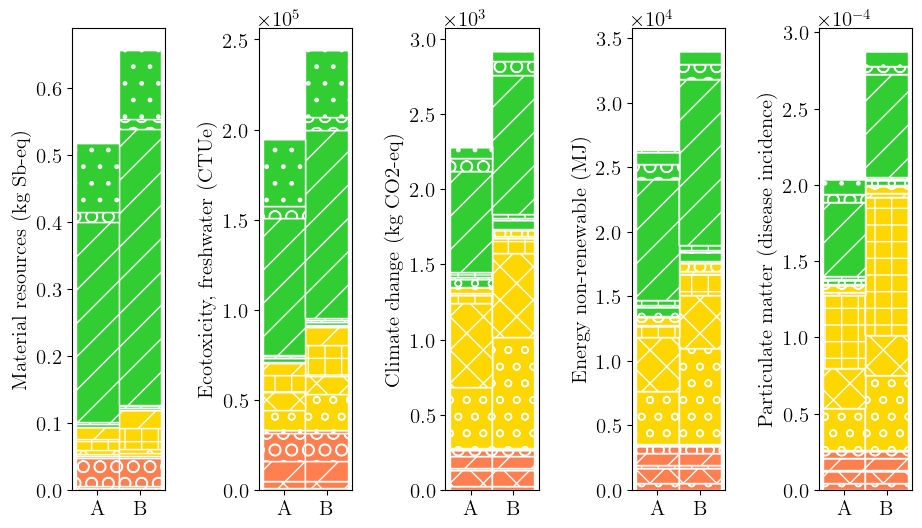

In [47]:
####MATPLOTLIB SCRIPT####

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})
plt.rcParams['font.size'] = 15


score_12=pd.read_csv("lca_12_18/score_12_V2.csv",index_col='Unnamed: 0')
score_18=pd.read_csv("lca_12_18/score_18_V2.csv",index_col='Unnamed: 0')

fig, ax = plt.subplots(nrows=1,ncols=categories_shortlist, figsize=(42, 6), sharey=False) 

fig.subplots_adjust(wspace=1)  # Adjust the space between subplots
for n in range(categories_shortlist):
    width = 1
    bottom_12 = np.zeros(n+1) ## it just works
    bottom_18 = np.zeros(n+1) ## it just works
    i=0 #index for color and hatch
    hatch=['o','x', '+', '/','O','.','|','o','x','+','/','O','.','o','x', '+', '/','O','.','|' ]

    face_color=['coral','coral','coral','coral','coral','coral','coral','gold','gold','gold','gold','gold','gold','limegreen','limegreen','limegreen','limegreen','limegreen','limegreen','limegreen']
    for (part_12, impacts_12),(part_18, impacts_18) in zip(score_12.iterrows(),score_18.iterrows()):
        impact_12=impacts_12[n]
        impact_18=impacts_18[n]
        p_12 = ax[n].bar('A',impact_12, width, label=part_12, bottom=bottom_12,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
        p_18 = ax[n].bar('B',impact_18, width, label=part_18, bottom=bottom_18,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
        bottom_12 += impact_12
        bottom_18+= impact_18
       
        i+=1
    
    plt.subplots_adjust(left=0.45,right=0.65) ## brute force way of craming charts together

    
    ax[n].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax[n].ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))  

    ax[n].set_ylabel(impacts_order[n]+' ('+correspondances[impacts_order[n]]+')')
    
fig.savefig("figures/impacts_12_18_offgrid.svg")
    
plt.show()

In [48]:
## compute impacts per kwh ##
score_12=pd.read_csv("lca_12_18/score_12_V2.csv",index_col='Unnamed: 0')
score_18=pd.read_csv("lca_12_18/score_18_V2.csv",index_col='Unnamed: 0')
score_kwh_12=score_12.sum(axis=0)
score_kwh_12=score_kwh_12/lue_sc[0].item()
score_kwh_18=score_18.sum(axis=0)
score_kwh_18=score_kwh_18/lue_sc[1].item()

scores_kwh={
    'Categories':impacts_order,
    '12m':score_kwh_12,
    '18m':score_kwh_18
}
scores_kwh_df=pd.DataFrame(scores_kwh)
scores_kwh_df

,Categories,12m,18m
11,Material resources,6.109443e-05,5.607155e-05
2,"Ecotoxicity, freshwater",2.297689e+01,2.084542e+01
1,Climate change,2.693460e-01,2.497995e-01
3,Energy non-renewable,3.101784e+00,2.910090e+00
13,Particulate matter,2.409784e-08,2.462063e-08


In [49]:
# Contribution analysis
score_18.to_csv("lca_12_18/score_18_decimal_V2.csv",decimal=',')

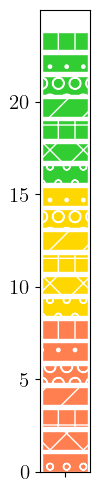

In [50]:
# generate legend
i=0
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(2.5, 6), sharey=False) # Creates figure and axis
bottom = 0 ## it just works
for boolean, d in score.items():
    p = ax.bar(' ',1, width, label=boolean, bottom=bottom,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
   # p2 = ax[1].bar(' ',boolean, width, label=boolean, bottom=bottom,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
    plt.subplots_adjust(left=0.45,right=0.65) ## brute force way of craming charts together  
    i+=1
    bottom+=1.2
plt.show()
fig.savefig("figures/legend.svg")

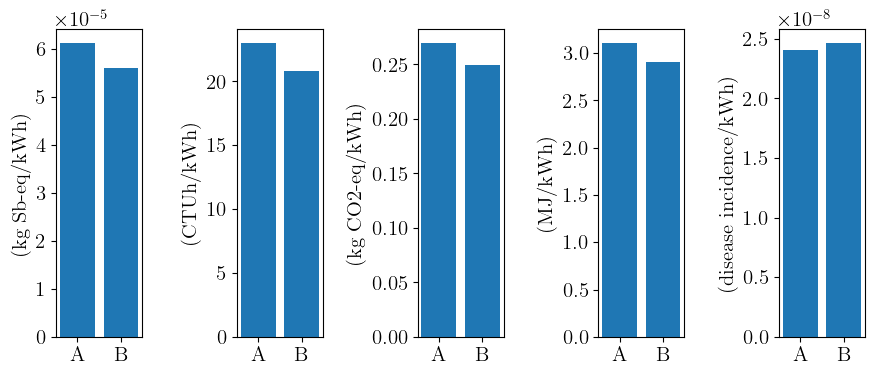

In [51]:
####PLOT IMPACTS/KWH####

df=scores_kwh_df
bar_width = 0.2
index = range(len(df['Categories']))

fig, axes = plt.subplots(nrows=1, ncols=len(df), figsize=(9,4))

for i, (index, row) in enumerate(df.iterrows()):
    ax = axes[i]
    ax.bar(['A', 'B'], [row['12m'], row['18m']])
    ax.set_ylabel(' ('+correspondances_kwh[impacts_order[i]]+')')
    ax.set_ylim(0, 1.05*max(row['12m'], row['18m']))  
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.tight_layout() 
plt.show() 

fig.savefig("figures/impacts_kwh_V2.svg")

# Grid tied

## For a 18 m mast

In [52]:
activities_electronics_grid[3]

'grid_electricity' (unit, GLO, None)

In [53]:
# Scale grid electricity for 18 m energy yield

act_grid=activities_electronics_grid[3]# activites are concatenated
grid_key = Database('electronics_wind_turbine_oswacc').search('market group for electricity, low voltage')[0].key
grid_exc = [i for i in act_grid.exchanges() if i['input'] == grid_key][0]

grid_exc.as_dict()['amount'] =  leg[1] 
grid_exc.save()

activities_18_grid=activities_wt+activities_18m+activities_electronics_grid
order_18_grid = order_wt | order_18m | order_electronics_grid

activities_18_grid

['production of wind turbine wood only' (unit, GLO, None),
 'production of wind turbine steel only' (unit, GLO, None),
 'production of wind turbine resin only' (unit, GLO, None),
 'production of wind turbine magnet only' (unit, GLO, None),
 'production of wind turbine copper only' (unit, GLO, None),
 'production of wind turbine other materials only' (unit, GLO, None),
 'transport of wind turbine' (unit, GLO, None),
 'production of 18m structure steel no zinc' (unit, GLO, None),
 'production of 18m structure concrete only' (unit, GLO, None),
 'production of 18m zinc coat' (unit, GLO, None),
 'production of mast cable 48V' (unit, GLO, None),
 'transport of 18m concrete structure' (unit, GLO, None),
 'transport of 18m steel structure' (unit, GLO, None),
 'rectifier final' (unit, GLO, None),
 'charge controller final' (unit, GLO, None),
 'dump load final' (unit, GLO, None),
 'grid_electricity' (unit, GLO, None),
 'inverter final' (unit, GLO, None),
 'cable final' (unit, GLO, None),
 'trans

In [54]:
grid_exc

Exchange: 13128.839034462486 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, Europe without Switzerland, None) to 'grid_electricity' (unit, GLO, None)>

In [55]:
####COMPUTE LCIA RESULTS FOR ALL METHODS####
score={}
for i in range(len(order_18_grid)): #Cycle through activities
    array_score=np.zeros(len(methods_EF)) #Results are in a np array
    for j in range(len(methods_EF)): # Cycle through methods
        lca = LCA(demand={activities_18_grid[i]:1},
                 method=methods_EF[j])
        lca.lci()
        lca.lcia()
        #score.append(lca.score)
        array_score[j]=lca.score #store result
    score[list(order_18_grid.keys())[i]]=array_score # Store the np.array in the score dictionary for easier handling 



In [56]:
store_score_18_grid = pd.DataFrame.from_dict(score,orient='index')
store_score_18_grid
store_score_18_grid.to_csv("lca_12_18/score_18_grid_full_impacts.csv")

In [57]:
contributions_18_grid={}

for i in range(len(order_18_grid)):
    contributions_18_grid[list(score.keys())[i]]=EF_single_score(score[list(score.keys())[i]],NF,WF)
contributions_18_grid_df=pd.DataFrame.from_dict(contributions_18_grid,orient='index')
contributions_18_grid_df.to_csv("lca_12_18/contributions_18_grid.csv",decimal=",")

In [58]:
# compute EF 3.0 single score
score_18_grid=np.zeros((len(methods_EF),2))
for i in range(len(methods_EF)): # iterate in categories
   score_18_grid[i,0]=i
   score_18_grid[i,1]=np.sum(store_score_18_grid[i])  # sum of scores for all activities 
score_18_grid

array([[0.00000000e+00, 5.43143704e+01],
       [1.00000000e+00, 7.24804167e+03],
       [2.00000000e+00, 2.14617343e+05],
       [3.00000000e+00, 1.32382169e+05],
       [4.00000000e+00, 6.59824426e+00],
       [5.00000000e+00, 9.66131712e+00],
       [6.00000000e+00, 1.10405044e+02],
       [7.00000000e+00, 1.04501701e-05],
       [8.00000000e+00, 2.21274617e-04],
       [9.00000000e+00, 3.17993398e+03],
       [1.00000000e+01, 4.55018979e+04],
       [1.10000000e+01, 2.93540733e-01],
       [1.20000000e+01, 4.08220148e-04],
       [1.30000000e+01, 3.15260565e-04],
       [1.40000000e+01, 2.10106876e+01],
       [1.50000000e+01, 3.79035626e+03]])

In [59]:
single_score=EF_single_score(score_18_grid[:,1],NF,WF)
scorenorm=np.column_stack((score_18_grid,score_18_grid[:,1]/NF*WF))
scorenorm

array([[0.00000000e+00, 5.43143704e+01, 6.05663843e-02],
       [1.00000000e+00, 7.24804167e+03, 1.88449083e-01],
       [2.00000000e+00, 2.14617343e+05, 9.65024120e-02],
       [3.00000000e+00, 1.32382169e+05, 1.69449177e-01],
       [4.00000000e+00, 6.59824426e+00, 1.14752074e-01],
       [5.00000000e+00, 9.66131712e+00, 1.46653839e-02],
       [6.00000000e+00, 1.10405044e+02, 2.31413962e-02],
       [7.00000000e+00, 1.04501701e-05, 1.31709244e-02],
       [8.00000000e+00, 2.21274617e-04, 1.77019693e-02],
       [9.00000000e+00, 3.17993398e+03, 3.77522967e-02],
       [1.00000000e+01, 4.55018979e+04, 4.41129511e-03],
       [1.10000000e+01, 2.93540733e-01, 3.48464235e-01],
       [1.20000000e+01, 4.08220148e-04, 4.80572600e-04],
       [1.30000000e+01, 3.15260565e-04, 4.74745322e-02],
       [1.40000000e+01, 2.10106876e+01, 2.47367209e-02],
       [1.50000000e+01, 3.79035626e+03, 2.80486363e-02]])

In [60]:
scorenorm=np.column_stack((scorenorm,scorenorm[:,2]/single_score))
scorenorm

array([[0.00000000e+00, 5.43143704e+01, 6.05663843e-02, 5.09060846e-02],
       [1.00000000e+00, 7.24804167e+03, 1.88449083e-01, 1.58391575e-01],
       [2.00000000e+00, 2.14617343e+05, 9.65024120e-02, 8.11103388e-02],
       [3.00000000e+00, 1.32382169e+05, 1.69449177e-01, 1.42422141e-01],
       [4.00000000e+00, 6.59824426e+00, 1.14752074e-01, 9.64491914e-02],
       [5.00000000e+00, 9.66131712e+00, 1.46653839e-02, 1.23262645e-02],
       [6.00000000e+00, 1.10405044e+02, 2.31413962e-02, 1.94503583e-02],
       [7.00000000e+00, 1.04501701e-05, 1.31709244e-02, 1.10701703e-02],
       [8.00000000e+00, 2.21274617e-04, 1.77019693e-02, 1.48785165e-02],
       [9.00000000e+00, 3.17993398e+03, 3.77522967e-02, 3.17308295e-02],
       [1.00000000e+01, 4.55018979e+04, 4.41129511e-03, 3.70769635e-03],
       [1.10000000e+01, 2.93540733e-01, 3.48464235e-01, 2.92884412e-01],
       [1.20000000e+01, 4.08220148e-04, 4.80572600e-04, 4.03921576e-04],
       [1.30000000e+01, 3.15260565e-04, 4.74745322e

In [61]:
scorenorm_df=pd.DataFrame(scorenorm,columns=['Category number', 'Raw score', 'Normalized_Weighted', 'Score_ratio'])


In [62]:
I=np.argsort(-scorenorm_df.Score_ratio) #sort descending
score_sort=scorenorm[I,:]


In [63]:
score_sort=np.column_stack((score_sort,np.zeros(len(methods_EF))))
sum_ratio=0
methods_80=[]
m=0
for i in range(len(methods_EF)):
    sum_ratio+=score_sort[i,3]
    score_sort[i,4]=sum_ratio
    if sum_ratio<0.8:
        m+=1
for i in range(m):
    methods_80.append(methods_EF[int(score_sort[i,0])][1])
print('The methods cumulating at least 80% of impacts are',methods_80)


The methods cumulating at least 80% of impacts are ['material resources: metals/minerals', 'climate change', 'energy resources: non-renewable', 'eutrophication: freshwater', 'ecotoxicity: freshwater']


In [64]:
score_sort_df=pd.DataFrame(score_sort,columns=['Category_number', 'Raw score', 'Normalized_Weighted', 'Score_ratio', 'Cumulative'])
print(score_sort_df)

    Category_number      Raw score  Normalized_Weighted  Score_ratio  \
0              11.0       0.293541             0.348464     0.292884   
1               1.0    7248.041669             0.188449     0.158392   
2               3.0  132382.169217             0.169449     0.142422   
3               4.0       6.598244             0.114752     0.096449   
4               2.0  214617.343347             0.096502     0.081110   
5               0.0      54.314370             0.060566     0.050906   
6              13.0       0.000315             0.047475     0.039902   
7               9.0    3179.933978             0.037752     0.031731   
8              15.0    3790.356263             0.028049     0.023575   
9              14.0      21.010688             0.024737     0.020791   
10              6.0     110.405044             0.023141     0.019450   
11              8.0       0.000221             0.017702     0.014879   
12              5.0       9.661317             0.014665     0.01

In [65]:
for i in range(len(I)):
    score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]
print(score_sort_df)
score_sort_df.to_csv("lca_12_18/score_18_grid_methods_choice.csv",decimal=",")

                                Category_number      Raw score  \
0           material resources: metals/minerals       0.293541   
1                                climate change    7248.041669   
2               energy resources: non-renewable  132382.169217   
3                    eutrophication: freshwater       6.598244   
4                       ecotoxicity: freshwater  214617.343347   
5                                 acidification      54.314370   
6                  particulate matter formation       0.000315   
7              ionising radiation: human health    3179.933978   
8                                     water use    3790.356263   
9   photochemical ozone formation: human health      21.010688   
10                  eutrophication: terrestrial     110.405044   
11             human toxicity: non-carcinogenic       0.000221   
12                       eutrophication: marine       9.661317   
13                 human toxicity: carcinogenic       0.000010   
14        

/tmp/ipykernel_5315/551973433.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'material resources: metals/minerals' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]


In [66]:
####Select LCIA RESULTS FOR MOST RELEVANT METHODS####

categories_shortlist=5
store_score_18_grid_rec=store_score_18_grid[I[0:categories_shortlist]]

In [67]:

store_score_18_grid_rec.to_csv("lca_12_18/score_18_grid_V2.csv")

store_score_18_grid_rec

,11,1,3,4,2
wood,0.000223,23.647301,503.078317,0.012605,955.401997
steel,0.002670,109.014878,1192.274770,0.051025,3885.668682
resin,0.000115,9.791659,222.464715,0.002353,317.317040
magnet,0.002540,84.274904,920.306774,0.031242,10699.940429
copper,0.042005,38.258497,556.169076,0.140188,15894.202583
other,0.003675,7.095496,113.254149,0.014506,1357.488502
transport,0.000011,3.325971,48.476418,0.000334,40.504873
18m steel no zinc,0.003454,741.831310,7461.142387,0.364031,20314.440381
18m concrete,0.005701,556.245056,4115.119432,0.098739,9707.523209
18m zinc,0.031257,98.757743,1619.171042,0.079537,17432.865991


## For 12m mast

In [68]:
# scale grid energy for energy needs
grid_exc.as_dict()['amount'] =  leg[0] 
grid_exc.save()


activities_12_grid =activities_wt+activities_12m+activities_electronics_grid
order_12_grid = order_wt | order_12m | order_electronics_grid

activities_12_grid

['production of wind turbine wood only' (unit, GLO, None),
 'production of wind turbine steel only' (unit, GLO, None),
 'production of wind turbine resin only' (unit, GLO, None),
 'production of wind turbine magnet only' (unit, GLO, None),
 'production of wind turbine copper only' (unit, GLO, None),
 'production of wind turbine other materials only' (unit, GLO, None),
 'transport of wind turbine' (unit, GLO, None),
 'production of 12m structure steel no zinc' (unit, GLO, None),
 'production of 12m structure concrete only' (unit, GLO, None),
 'production of 12m zinc coat' (unit, GLO, None),
 'production of mast cable 48V' (unit, GLO, None),
 'transport of 12m concrete structure' (unit, GLO, None),
 'transport of 12m steel structure' (unit, GLO, None),
 'rectifier final' (unit, GLO, None),
 'charge controller final' (unit, GLO, None),
 'dump load final' (unit, GLO, None),
 'grid_electricity' (unit, GLO, None),
 'inverter final' (unit, GLO, None),
 'cable final' (unit, GLO, None),
 'trans

In [69]:
score={}
for i in range(len(order_12_grid)): #Cycle through activities
    array_score=np.zeros(len(methods_EF)) #Results are in a np array
    for j in range(len(methods_EF)): # Cycle through methods
        lca = LCA(demand={activities_12_grid[i]:1},
                 method=methods_EF[j])
        lca.lci()
        lca.lcia()
        #score.append(lca.score)
        array_score[j]=lca.score #store result
    score[list(order_12_grid.keys())[i]]=array_score # Store the np.array in the score dictionary for easier handling 



In [70]:
store_score_12_grid = pd.DataFrame.from_dict(score,orient='index')
store_score_12_grid
store_score_12_grid.to_csv("lca_12_18/score_12_grid_full_impacts_v2.csv")

In [71]:
contributions_12_grid={}
for i in range(len(order_12_grid)):
    contributions_12_grid[list(score.keys())[i]]=EF_single_score(score[list(score.keys())[i]],NF,WF)
contributions_12_grid_df=pd.DataFrame.from_dict(contributions_12_grid,orient='index')
contributions_12_grid_df.to_csv("lca_12_18/contributions_12_grid_V2.csv",decimal=",")

In [72]:
# compute EF 3.0 single score
score_12_grid=np.zeros((len(methods_EF),2))
for i in range(len(methods_EF)):
   score_12_grid[i,0]=i
   score_12_grid[i,1]=np.sum(store_score_12_grid[i])  
score_12_grid

array([[0.00000000e+00, 4.00012097e+01],
       [1.00000000e+00, 5.41613432e+03],
       [2.00000000e+00, 1.73552757e+05],
       [3.00000000e+00, 9.75200866e+04],
       [4.00000000e+00, 4.92358864e+00],
       [5.00000000e+00, 7.77316702e+00],
       [6.00000000e+00, 7.56620040e+01],
       [7.00000000e+00, 7.62110295e-06],
       [8.00000000e+00, 1.82134993e-04],
       [9.00000000e+00, 2.32438855e+03],
       [1.00000000e+01, 3.86188898e+04],
       [1.10000000e+01, 2.55263538e-01],
       [1.20000000e+01, 3.12044309e-04],
       [1.30000000e+01, 2.23926414e-04],
       [1.40000000e+01, 1.60062944e+01],
       [1.50000000e+01, 2.76779823e+03]])

In [73]:
single_score=EF_single_score(score_12_grid[:,1],NF,WF)
scorenorm=np.column_stack((score_12_grid,score_12_grid[:,1]/NF*WF))
scorenorm

array([[0.00000000e+00, 4.00012097e+01, 4.46056655e-02],
       [1.00000000e+00, 5.41613432e+03, 1.40819492e-01],
       [2.00000000e+00, 1.73552757e+05, 7.80377735e-02],
       [3.00000000e+00, 9.75200866e+04, 1.24825711e-01],
       [4.00000000e+00, 4.92358864e+00, 8.56276285e-02],
       [5.00000000e+00, 7.77316702e+00, 1.17992689e-02],
       [6.00000000e+00, 7.56620040e+01, 1.58590980e-02],
       [7.00000000e+00, 7.62110295e-06, 9.60529544e-03],
       [8.00000000e+00, 1.82134993e-04, 1.45707994e-02],
       [9.00000000e+00, 2.32438855e+03, 2.75952290e-02],
       [1.00000000e+01, 3.86188898e+04, 3.74400470e-03],
       [1.10000000e+01, 2.55263538e-01, 3.03025113e-01],
       [1.20000000e+01, 3.12044309e-04, 3.67350670e-04],
       [1.30000000e+01, 2.23926414e-04, 3.37206835e-02],
       [1.40000000e+01, 1.60062944e+01, 1.88448491e-02],
       [1.50000000e+01, 2.76779823e+03, 2.04817069e-02]])

In [74]:
scorenorm=np.column_stack((scorenorm,scorenorm[:,2]/single_score))
scorenorm

array([[0.00000000e+00, 4.00012097e+01, 4.46056655e-02, 4.77817331e-02],
       [1.00000000e+00, 5.41613432e+03, 1.40819492e-01, 1.50846295e-01],
       [2.00000000e+00, 1.73552757e+05, 7.80377735e-02, 8.35943154e-02],
       [3.00000000e+00, 9.75200866e+04, 1.24825711e-01, 1.33713705e-01],
       [4.00000000e+00, 4.92358864e+00, 8.56276285e-02, 9.17245926e-02],
       [5.00000000e+00, 7.77316702e+00, 1.17992689e-02, 1.26394150e-02],
       [6.00000000e+00, 7.56620040e+01, 1.58590980e-02, 1.69883171e-02],
       [7.00000000e+00, 7.62110295e-06, 9.60529544e-03, 1.02892235e-02],
       [8.00000000e+00, 1.82134993e-04, 1.45707994e-02, 1.56082875e-02],
       [9.00000000e+00, 2.32438855e+03, 2.75952290e-02, 2.95600985e-02],
       [1.00000000e+01, 3.86188898e+04, 3.74400470e-03, 4.01058994e-03],
       [1.10000000e+01, 2.55263538e-01, 3.03025113e-01, 3.24601480e-01],
       [1.20000000e+01, 3.12044309e-04, 3.67350670e-04, 3.93507226e-04],
       [1.30000000e+01, 2.23926414e-04, 3.37206835e

In [75]:
scorenorm_df=pd.DataFrame(scorenorm,columns=['Category number', 'Raw score', 'Normalized_Weighted', 'Score_ratio'])


In [76]:
I=np.argsort(-scorenorm_df.Score_ratio) #sort descending
score_sort=scorenorm[I,:]


In [77]:
score_sort=np.column_stack((score_sort,np.zeros(len(methods_EF))))
sum_ratio=0
methods_80=[]
m=1
for i in range(len(methods_EF)):
    sum_ratio+=score_sort[i,3]
    score_sort[i,4]=sum_ratio
    if sum_ratio<0.8:
        m+=1
for i in range(m):
    methods_80.append(methods_EF[int(score_sort[i,0])][1])

print('The methods cumulating at least 80% of impacts are',methods_80)


The methods cumulating at least 80% of impacts are ['material resources: metals/minerals', 'climate change', 'energy resources: non-renewable', 'eutrophication: freshwater', 'ecotoxicity: freshwater', 'acidification']


In [78]:
score_sort_df=pd.DataFrame(score_sort,columns=['Category_number', 'Raw score', 'Normalized_Weighted', 'Score_ratio', 'Cumulative'])


In [79]:
for i in range(len(I)):
    score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]
print(score_sort_df)
score_sort_df.to_csv("lca_12_18/score_12_grid_methods_choice_V2.csv",decimal=",")

                                Category_number      Raw score  \
0           material resources: metals/minerals       0.255264   
1                                climate change    5416.134317   
2               energy resources: non-renewable   97520.086631   
3                    eutrophication: freshwater       4.923589   
4                       ecotoxicity: freshwater  173552.756739   
5                                 acidification      40.001210   
6                  particulate matter formation       0.000224   
7              ionising radiation: human health    2324.388547   
8                                     water use    2767.798226   
9   photochemical ozone formation: human health      16.006294   
10                  eutrophication: terrestrial      75.662004   
11             human toxicity: non-carcinogenic       0.000182   
12                       eutrophication: marine       7.773167   
13                 human toxicity: carcinogenic       0.000008   
14        

/tmp/ipykernel_5315/2120973313.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'material resources: metals/minerals' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  score_sort_df.Category_number[i]=methods_EF[int(I[i])][1]


In [88]:
####Select LCIA RESULTS FOR MOST RELEVANT METHODS####
categories_shortlist=5
store_score_12_grid_rec=store_score_12_grid[I[0:categories_shortlist]]
store_score_12_grid_rec.to_csv("lca_12_18/score_12_grid_V2.csv")

In [89]:
store_score_12_grid_rec

,11,1,3,4,2
wood,0.000223,23.647301,503.078317,0.012605,955.401997
steel,0.002670,109.014878,1192.274770,0.051025,3885.668682
resin,0.000115,9.791659,222.464715,0.002353,317.317040
magnet,0.002540,84.274904,920.306774,0.031242,10699.940429
copper,0.042005,38.258497,556.169076,0.140188,15894.202583
other,0.003675,7.095496,113.254149,0.014506,1357.488502
transport,0.000011,3.325971,48.476418,0.000334,40.504873
12m steel no zinc,0.001952,411.424677,4138.454523,0.201126,11329.267859
12m concrete,0.005701,556.245056,4115.119432,0.098739,9707.523209
12m zinc,0.016912,53.367020,872.410728,0.043024,9429.620773


In [90]:
score_12_grid=pd.read_csv("lca_12_18/score_12_grid_V2.csv",index_col='Unnamed: 0')
score_12_grid

,11,1,3,4,2
wood,0.000223,23.647301,503.078317,0.012605,955.401997
steel,0.002670,109.014878,1192.274770,0.051025,3885.668682
resin,0.000115,9.791659,222.464715,0.002353,317.317040
magnet,0.002540,84.274904,920.306774,0.031242,10699.940429
copper,0.042005,38.258497,556.169076,0.140188,15894.202583
other,0.003675,7.095496,113.254149,0.014506,1357.488502
transport,0.000011,3.325971,48.476418,0.000334,40.504873
12m steel no zinc,0.001952,411.424677,4138.454523,0.201126,11329.267859
12m concrete,0.005701,556.245056,4115.119432,0.098739,9707.523209
12m zinc,0.016912,53.367020,872.410728,0.043024,9429.620773


In [91]:
score_18_grid=pd.read_csv("lca_12_18/score_18_grid_V2.csv",index_col='Unnamed: 0')
score_18_grid

,11,1,3,4,2
wood,0.000223,23.647301,503.078317,0.012605,955.401997
steel,0.002670,109.014878,1192.274770,0.051025,3885.668682
resin,0.000115,9.791659,222.464715,0.002353,317.317040
magnet,0.002540,84.274904,920.306774,0.031242,10699.940429
copper,0.042005,38.258497,556.169076,0.140188,15894.202583
other,0.003675,7.095496,113.254149,0.014506,1357.488502
transport,0.000011,3.325971,48.476418,0.000334,40.504873
18m steel no zinc,0.003454,741.831310,7461.142387,0.364031,20314.440381
18m concrete,0.005701,556.245056,4115.119432,0.098739,9707.523209
18m zinc,0.031257,98.757743,1619.171042,0.079537,17432.865991


/tmp/ipykernel_5315/4284819504.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  impact_12=impacts_12[n]
/tmp/ipykernel_5315/4284819504.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  impact_18=impacts_18[n]


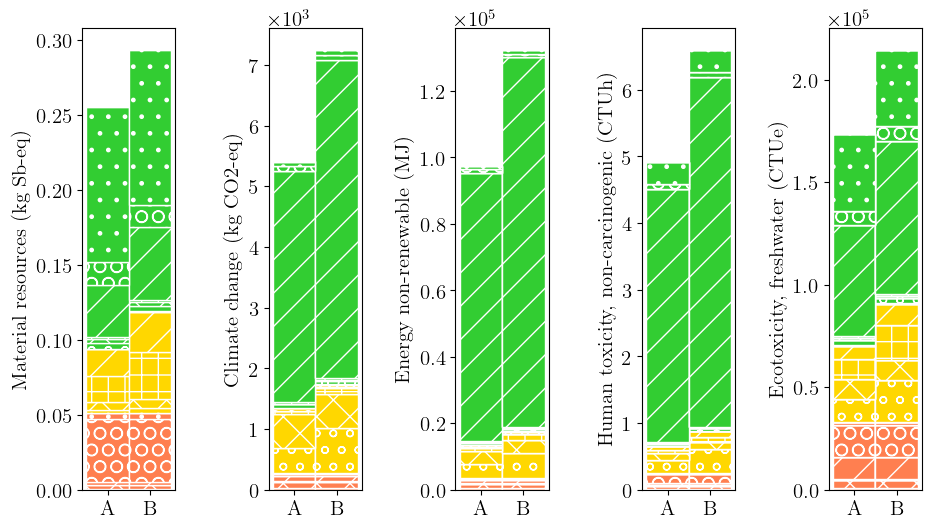

In [92]:
####MATPLOTLIB SCRIPT####

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})
plt.rcParams['font.size'] = 15


score_12=pd.read_csv("lca_12_18/score_12_grid_V2.csv",index_col='Unnamed: 0')
score_18=pd.read_csv("lca_12_18/score_18_grid_V2.csv",index_col='Unnamed: 0')

fig, ax = plt.subplots(nrows=1,ncols=categories_shortlist, figsize=(42, 6), sharey=False) # Creates figure and axis

fig.subplots_adjust(wspace=1)  
for n in range(categories_shortlist):
    width = 1
    bottom_12 = np.zeros(n+1) ## it just works
    bottom_18 = np.zeros(n+1) ## it just works
    i=0 #index for color and hatch
    hatch=['o','x', '+', '/','O','.','|','o','x','+','/','O','.','o','x', '+', '/','O','.','|' ]

    face_color=['coral','coral','coral','coral','coral','coral','coral','gold','gold','gold','gold','gold','gold','limegreen','limegreen','limegreen','limegreen','limegreen','limegreen','limegreen']
    for (part_12, impacts_12),(part_18, impacts_18) in zip(score_12.iterrows(),score_18.iterrows()):
        impact_12=impacts_12[n]
        impact_18=impacts_18[n]
        p_12 = ax[n].bar('A',impact_12, width, label=part_12, bottom=bottom_12,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
        p_18 = ax[n].bar('B',impact_18, width, label=part_18, bottom=bottom_18,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
        bottom_12 += impact_12
        bottom_18+= impact_18

        i+=1
    

    plt.subplots_adjust(left=0.45,right=0.65) ## brute force way of craming charts together


    ax[n].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax[n].ticklabel_format(axis='y', style='sci', scilimits=(-2, 2)) 

    ax[n].set_ylabel(impacts_order_grid[n]+' ('+correspondances[impacts_order_grid[n]]+')')
    
fig.savefig("figures/impacts_12_18_grid.svg")
plt.show()

In [93]:
## compute impacts per kwh ##
score_12=pd.read_csv("lca_12_18/score_12_grid_V2.csv",index_col='Unnamed: 0')
score_18=pd.read_csv("lca_12_18/score_18_grid_V2.csv",index_col='Unnamed: 0')
score_kwh_12=score_12.sum(axis=0)
score_kwh_12=score_kwh_12/lue_grid[0].item()
score_kwh_18=score_18.sum(axis=0)
score_kwh_18=score_kwh_18/lue_grid[1].item()

scores_kwh={
    'Categories':impacts_order_grid[0:5],
    '12m':score_kwh_12,
    '18m':score_kwh_18
}
scores_kwh_df=pd.DataFrame(scores_kwh)
scores_kwh_df

,Categories,12m,18m
11,Material resources,0.000021,0.000018
1,Climate change,0.455612,0.441656
3,Energy non-renewable,8.203519,8.066649
4,"Human toxicity, non-carcinogenic",0.000414,0.000402
2,"Ecotoxicity, freshwater",14.599488,13.077613


In [94]:
# Contribution analysis
score_18.to_csv("lca_12_18/score_18_grid_decimal_V2.csv",decimal=',')

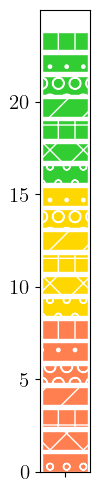

In [95]:
# generate legend
i=0
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(2.5, 6), sharey=False) # Creates figure and axis
bottom = 0 ## it just works
for boolean, d in score.items():
    p = ax.bar(' ',1, width, label=boolean, bottom=bottom,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
   # p2 = ax[1].bar(' ',boolean, width, label=boolean, bottom=bottom,facecolor=face_color[i],hatch=hatch[i],edgecolor='w')
    plt.subplots_adjust(left=0.45,right=0.65) ## brute force way of craming charts together  
    i+=1
    bottom+=1.2
plt.show()
fig.savefig("figures/legend.svg")

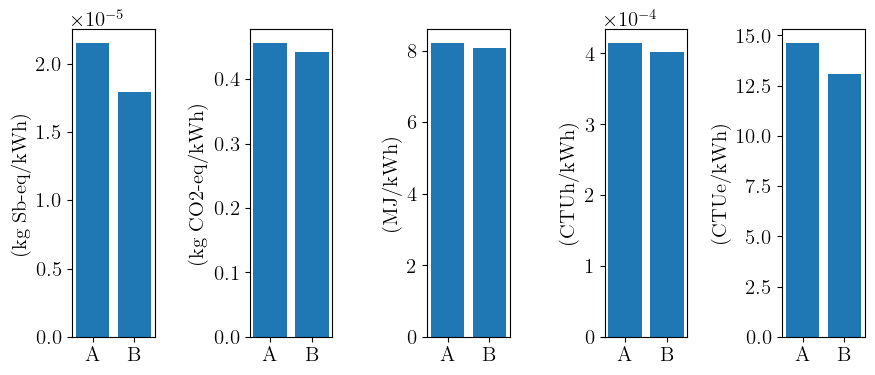

In [98]:
####PLOT IMPACTS/KWH####

df=scores_kwh_df
bar_width = 0.2
index = range(len(df['Categories']))

# Creating subplots for each category
fig, axes = plt.subplots(nrows=1, ncols=len(df), figsize=(9,4))

# Plotting each category with different y-axis limits
for i, (index, row) in enumerate(df.iterrows()):
    ax = axes[i]
    ax.bar(['A', 'B'], [row['12m'], row['18m']])
    ax.set_ylabel(' ('+correspondances_kwh[impacts_order_grid[i]]+')')
    ax.set_ylim(0, 1.05*max(row['12m'], row['18m']))  # Setting different y-axis limits for each category
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.tight_layout()  # To ensure the subplots are properly arranged
plt.show()  # Display the plot

fig.savefig("figures/impacts_kwh_grid.svg")

# Sizing of the mast

Until now the LCIA results were growing linearly with respect to the mast length. We now want to take into account the real dimensions of the mast. The three dimensions modified are the outer diameter of the steel tube, the diameter of the the steel guys and the area of wire to coat in zinc. 

## Guy wire

### Cable section

To verify the cable diameter, we first need the Force exerted by the wind on the wind turbine hub $F_{wind}$. We can then compute the force exerted on the cable $F_\alpha$.

$F_{wind}=\cos(\alpha)F_\alpha$

with : 

$\alpha = 60°$ the angle formed between the cable and the ground.

This part of the code displays the relationship between the cable section and the maximum break force according to the datasheet. It also defines the number of samples $n$ used throughout our code for the LCA.

In [99]:
import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt

#plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 15
####From datasheet####

#Diameters included in the datasheet
Diameter = np.array([3,3.5,4,5,6,8,9,10,12])
Diameter = Diameter/1000
Section = np.pi*(Diameter/2)**2

# number of samples n
n = 12

$S_{real}=S_{eq}\times k$

with $k$ the fill factor in our case $ k = 0,51$

For the LCA we will need the Section of cable and its length depending on the mast length

$S_{real}=\frac{k c_{sec}}{a}\left(\frac{F_{wind}(L)}{\cos(\alpha)}-b\right)$

with : 

$c_{sec}$ the safety coefficient

$k$ the fill factor

$L$ the mast length

### Cable length

For the length of the top guy wires $L_c$, we have : 

$L_c = \frac{4L}{\sin(\alpha)} = \frac{8L}{\sqrt3}$

Smaller cable are used to strengthen the mast tube with a diameter considered constant of 6 mm. They are connected to the same anchorage as the top cable but they are connected to the mast at 6 m, 12 m and 18 m with a length of $\lambda_1$, $\lambda_2$ and $\lambda_3$.

$\lambda_1 = 4\sqrt{\left(\frac{L}{2}\right)^2+6^2}$

$\lambda_2 = 4\sqrt{\left(\frac{L}{2}\right)^2+12^2}$


$\lambda_3 = 4\sqrt{\left(\frac{L}{2}\right)^2+18^2}$


The smaller cables have a Section of 6 mm noted $S_{6mm}$

$S_{6mm} = k \pi \left(\frac{0,006}{2}\right)^2 = 1,44\times10^{-5} $ m²

We can now compute the mass of steel used for the cables

$m_{cable}= \rho_{steel} \left(L_c S+\lambda_1 S_{6mm}+\lambda_2 S_{6mm}+\lambda_3 S_{6mm}\right)$

$m_{cable}= \rho_{steel} \left(\frac{8L}{\sqrt3} \frac{k c_{sec}}{a}\left(\frac{F_{wind}(L)}{\cos(\alpha)}-b\right)+4\sqrt{\left(\frac{L}{2}\right)^2+6^2} \times S_{6mm}+4\sqrt{\left(\frac{L}{2}\right)^2+12^2} \times S_{6mm}  +4\sqrt{\left(\frac{L}{2}\right)^2+18^2} \times S_{6mm}\right)$

In this code we compute the mass of cable twice because we do it once analytically with continuous diameters and once for the actual build with discrete diameters. The discrete version takes into account the third layer of wire.

In [100]:
#fill factor
k = 0.51
#section of wire in mm^2
S_6 = k*np.pi * (0.006/2)**2
#This coefficient between 0 an 1 defines at which point between 12 and 18 do we add a third layer of cable
coef_add_cable = 0.5

Length = np.array([12, 18, 24])
l_wire=np.zeros(3)
m_wire=np.zeros(3)

#mild steel density
rho = 7850

lambda_6=4 * np.sqrt((12/2)**2+(6)**2)

for i,L in enumerate(Length):
    lambda_12=4 * np.sqrt((L/2)**2+(12)**2)
    if L>12 : 
        lambda_18=4 * np.sqrt((L/2)**2+(18)**2) 
    else:
        lambda_18=0
    if L>18 : 
        lambda_24=4 * np.sqrt((L/2)**2+(24)**2) 
    else:
        lambda_24=0  
    l_wire[i]=(lambda_6+lambda_12+lambda_18+lambda_24)
    m_wire[i] =rho * S_6 * l_wire[i]

m_wire_fit=np.polyfit(Length,m_wire,1)

In [101]:
l_wire

array([ 87.60675696, 174.43957269, 295.68787002])

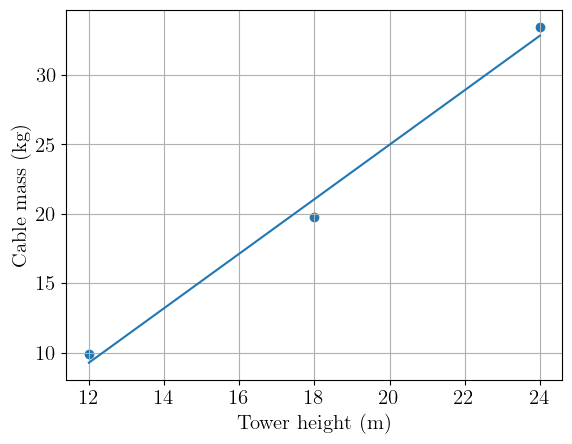

In [102]:
fig, ax = plt.subplots()


ax.set_xlabel('Tower height (m)')
ax.set_ylabel('Cable mass (kg)')


ax.scatter(Length,m_wire)
ax.plot(Length,np.polyval(m_wire_fit,Length))
ax.grid(True)


### Cable area

We also need to compute the surface area coated in zinc. Our cables are manufactured using 6 thread of 19 steel wires therefore for our model of the coationg process we decided that all wires were coated as individual cables. Each single wire is 15 times smaller than the nominal diameter of the cable.

The coated area per meter of cable $A_m$ is therefore

$A_m = \frac{19\times 6\times \pi D}{15}$

In [103]:
D = 0.006
A = ((19*6*np.pi*D)/(15))*l_wire
area_coat_fit=np.polyfit(Length,A,1)

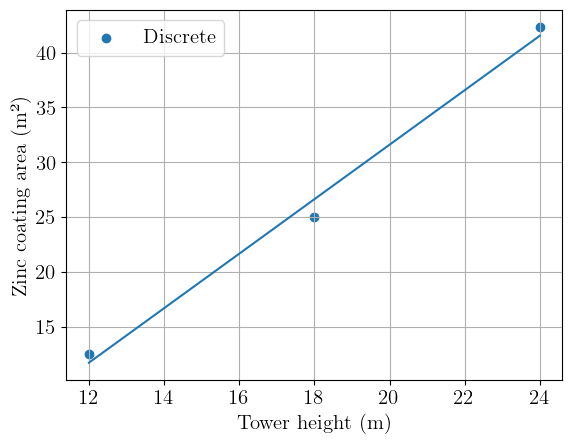

In [104]:
fig, ax = plt.subplots()


ax.set_xlabel('Tower height (m)')
ax.set_ylabel('Zinc coating area (m²)')

ax.scatter(Length,A,label='Discrete')
ax.plot(Length,np.polyval(area_coat_fit,Length))
ax.legend()
ax.grid(True)


## Mast pipe

In [105]:
from sympy import *
init_printing(use_unicode=True)
e,rho,L,a,b = symbols('e,rho,L,a,b')
mu,D,m = symbols ('mu,D,m',cls=Function)
D=a*L+b
mu = rho* pi*((D/2)**2-((D-2*e)/2)**2)
m=L*mu

print(latex(factor(m)))
factor(m)

\pi L e \rho \left(L a + b - e\right)


$m(L)=\pi L e \rho \left(L a + b - e\right)=KL(AL+B)$ with $K=\pi e \rho$, $A=a$ and $B=b-e$

In [106]:
del(e,rho,L,a,b,mu,D,m)

### Mast

In [107]:
rho = 7850
D = np.array([88.9,114.3,114.3])*1e-3
e = 3.2e-3
mu = rho* np.pi*((D/2)**2-((D-2*e)/2)**2)
L=np.linspace(12,24,200)

In [108]:
D_fit=np.polyfit(Length,D,1)
m_fit=np.polyfit(Length,mu*Length,2)
mu_fit_lin = rho* np.pi*((np.polyval(D_fit,L)/2)**2-((np.polyval(D_fit,L)-2*e)/2)**2)
m_fit_mu=np.pi*e*rho*L*(np.polyval(D_fit,L)-e)

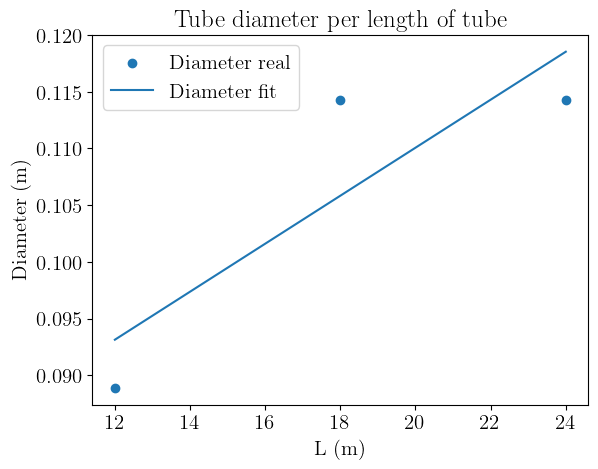

In [109]:
fig, ax = plt.subplots()
ax.set_title('Tube diameter per length of tube')
ax.set_xlabel('L (m)')
ax.set_ylabel('Diameter (m)')

ax.scatter(Length,D, label='Diameter real')
ax.plot(Length,np.polyval(D_fit,Length), label='Diameter fit')
ax.legend()
plt.show()

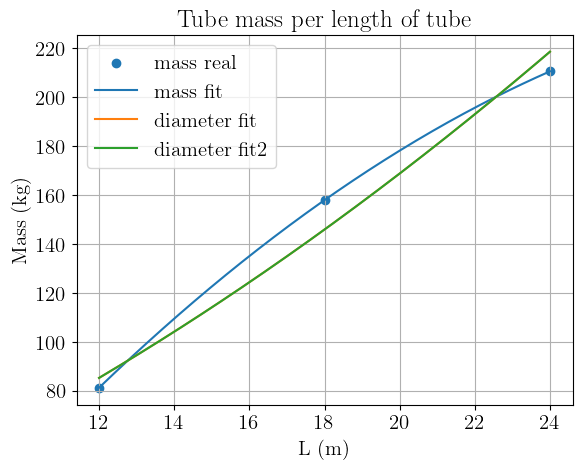

In [110]:
fig, ax = plt.subplots()
ax.set_title('Tube mass per length of tube')
ax.set_xlabel('L (m)')
ax.set_ylabel('Mass (kg)')
ax.scatter(Length,mu*Length, label='mass real')
ax.plot(L,np.polyval(m_fit,L),label='mass fit')
ax.plot(L,L*mu_fit_lin,label='diameter fit')
ax.plot(L,m_fit_mu,label='diameter fit2')
ax.legend()
ax.grid(True)
plt.show()

The mass fit is more representative of what is done on the field with the manual. However, it is obvious that the 18m mast diameter is over dimensionned since it is the same that for the 24 m mast. It is more physically realistic to choose the mass obtained from the linear interpolation of tube diameters for the present study.

### Yaw pipe

The yaw pipe helps raising the tower when it is lowered. In the handbook it is narrower than the mast and it measures half of its length. For the 12m tower the yaw pipe has an outter diameter of $D = 60,3$ $ mm $ and a thickness $ e = 2,9$ $mm$. For the 18m tower $D = 88,9$ $ mm $ and $ e = 3,2$ $mm$.

$ \frac{\rho_{acier} L}{2}   \times \pi\left(\left(\frac{D}{2}\right)^2-\left(\frac{D-2e}{2}\right)^2\right)$

In [111]:

e_yaw2 = 0.0032
D_yaw2 = 0.0889

e_yaw1 = 0.0029
D_yaw1 = 0.0603

e_yaw=np.array([e_yaw1, e_yaw2, e_yaw2])
D_yaw=np.array([D_yaw1, D_yaw2, D_yaw2])

D_yaw_fit=np.polyfit(Length,D_yaw,1)
e_yaw_fit=np.polyfit(Length,e_yaw,1)

m_yaw_fit=np.pi*np.polyval(e_yaw_fit,L)*rho*L/2*(np.polyval(D_yaw_fit,L)-np.polyval(e_yaw_fit,L))
m_yaw_real=Length/2*rho*np.pi*((D_yaw/2)**2-((D_yaw-2*e_yaw)/2)**2)

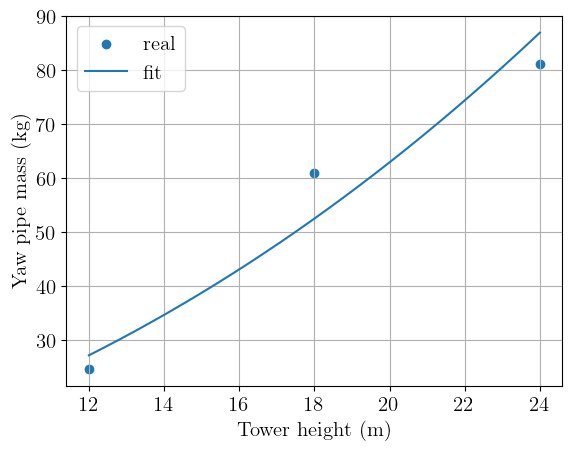

In [112]:

fig, ax = plt.subplots()

ax.set_xlabel(r'Tower height (m)')
ax.set_ylabel(r'Yaw pipe mass (kg)')

ax.scatter(Length,m_yaw_real,label='real')
ax.plot(L,m_yaw_fit,label='fit')

ax.grid(True)
ax.legend()


In [113]:
def tower_steel_tube_mass(L):
    e_yaw2 = 0.0032
    D_yaw2 = 0.0889

    e_yaw1 = 0.0029
    D_yaw1 = 0.0603

    e_yaw=np.array([e_yaw1, e_yaw2, e_yaw2])
    D_yaw=np.array([D_yaw1, D_yaw2, D_yaw2])

    D_yaw_fit=np.polyfit(Length,D_yaw,1)
    e_yaw_fit=np.polyfit(Length,e_yaw,1)
    
    rho = 7850
    D = np.array([88.9,114.3,114.3])*1e-3
    e = 3.2e-3
    mu = rho* np.pi*((D/2)**2-((D-2*e)/2)**2)

    m_yaw=np.pi*np.polyval(e_yaw_fit,L)*rho*L/2*(np.polyval(D_yaw_fit,L)-np.polyval(e_yaw_fit,L))
    m_mast=np.pi*e*rho*L*(np.polyval(D_fit,L)-e)
    return m_yaw+m_mast

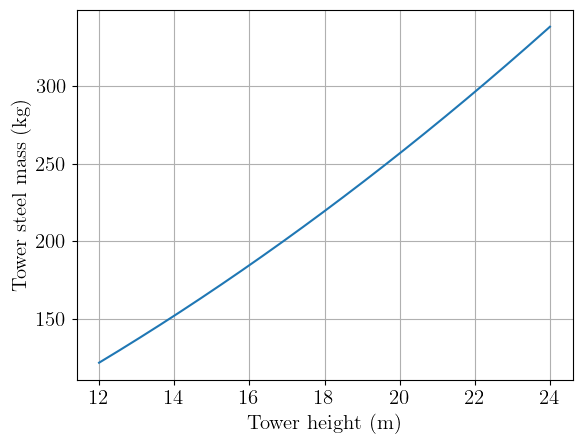

In [114]:
fig, ax = plt.subplots()
#ax.set_title('Yaw pipe mass for length of mast tube')
ax.set_xlabel(r'Tower height (m)')
ax.set_ylabel(r'Tower steel mass (kg)')
#ax.plot(L_corrected,m_tube,label='analytic')
ax.plot(L,tower_steel_tube_mass(L)+np.polyval(m_wire_fit,L))
ax.grid(True)
fig.savefig("figures/tow_steel.svg")


## Conclusion

From these we gathered three information, the mass of cable, the mass of tube and the area of cable.

# Back to LCIA

In [115]:
# Separate constant actitivities from scalable activities

order_cst_tower= dict(order_12m)
order_cst_tower.pop("12m steel no zinc")
order_cst_tower.pop("12m zinc")
order_cst_tower.pop("12m cable")
order_cst_tower.pop("12m transport steel")
order_cst_elec=dict(order_electronics)
order_cst_elec.pop("electronics batteries")

order_cst=order_wt|order_cst_tower|order_cst_elec
print(order_cst)

order_tower=dict(order_12m)
order_tower.pop("12m concrete")
order_tower.pop("12m transport concrete")
print(order_tower)

activities_cst=[Database('12m_wind_turbine').search(j)[0] for (i,j) in order_wt.items()]+[Database('12m_mast').search(j)[0] for (i,j) in order_cst_tower.items()]+[Database('electronics_wind_turbine_oswacc').search(j)[0] for (i,j) in order_cst_elec.items()]
print(activities_cst)
activities_batteries = [act_batteries]
print(activities_batteries)
activities_tower = [Database('12m_mast').search(j)[0] for (i,j) in order_tower.items()]
print(activities_tower)
activities_tow_cst=[Database('12m_mast').search(j)[0] for (i,j) in order_cst_tower.items()]
print(activities_tow_cst)


{'wood': 'production of wind turbine wood only', 'steel': 'production of wind turbine steel only', 'resin': 'production of wind turbine resin only', 'magnet': 'production of wind turbine magnet only', 'copper': 'production of wind turbine copper only', 'other': 'production of wind turbine other materials only', 'transport': 'transport of wind turbine', '12m concrete': 'production of 12m structure concrete only', '12m transport concrete': 'transport of 12m concrete structure', 'electronics rectifier': 'rectifier final', 'electronics charge controller': 'charge controller final', 'electronics dump load': 'dump load final', 'electronics inverter': 'inverter final', 'electronics cables': 'cable final', 'electronics transport': 'transport final'}
{'12m steel no zinc': 'production of 12m structure steel no zinc', '12m zinc': 'production of 12m zinc coat', '12m cable': 'production of mast cable 48V', '12m transport steel': 'transport of 12m steel structure'}
['production of wind turbine wood 

In [116]:
#### Calculate constant single score ####
 
cst_score=lca_single_score(activities_cst,methods_EF,NF,WF)

In [117]:
#### Calculate batteries single score ####
bat_score=lca_single_score(activities_batteries,methods_EF,NF,WF)

In [118]:
tow_score=lca_single_score(activities_tower,methods_EF,NF,WF)

In [119]:
tow_score_cst=lca_single_score(activities_tow_cst,methods_EF,NF,WF)

In [120]:
# check single score
print(cst_score+bat_score+tow_score)
print(tow_score_cst)

0.9669175048450271
0.05054646463035124


In [121]:
####SETTING VARIABLE HEIGHT####
# this defines the variable for our analysis it can also be an np.linspace

height=np.linspace(12,24,n)
tow_score=np.zeros(n)
tow_score_dict={'mast_length':height,'tower_score':tow_score}
# this dataframe contains all the scenarios, one for each height
tow_score_df = pd.DataFrame(tow_score_dict)

In [122]:
####SETTING QUANTITIES TO CHANGE####

# this process allows to update the value of each exchange when our height increases
act_steel=activities_12[7] # storing the activity name

# identifying in the ecoinvent DB the key corresponding to the exchange
pipe_key = Database('ecoinvent3.8 cut-off').search('drawing of pipe, steel', filter={'location':'RER'})[0].key 
# storing the exchange in a new variable
pipe_exc = [i for i in act_steel.exchanges() if i['input'] == pipe_key][0]

steel_ua_key = Database('ecoinvent3.8 cut-off').search('steel production, converter, unalloyed', filter={'location':'RER'})[0].key
steel_ua_exc =[i for i in act_steel.exchanges() if i['input'] == steel_ua_key][0]

wire_steel_key = Database('ecoinvent3.8 cut-off').search('wire drawing, steel', filter={'location':'RER'})[0].key
wire_steel_exc = [i for i in act_steel.exchanges() if i['input'] == wire_steel_key][0]


# We repeat for  zinc and cable activities
act_zinc=activities_12[9]

zinc_key = Database('ecoinvent3.8 cut-off').search('zinc coating, coils', filter={'location':'RER'})[0].key
zinc_exc = [i for i in act_zinc.exchanges() if i['input'] == zinc_key][0]

act_cable=activities_12[10]

copper_key=Database('ecoinvent3.8 cut-off').search('market for copper, cathode', filter={'location':'GLO'})[0].key
copper_exc = [i for i in act_cable.exchanges() if i['input'] == copper_key][0]

wire_key=Database('ecoinvent3.8 cut-off').search('wire drawing, copper', filter={'location':'RER'})[0].key
wire_exc = [i for i in act_cable.exchanges() if i['input'] == wire_key][0]

polyethylene_key=Database('ecoinvent3.8 cut-off').search('polyethylene production, high density, granulate', filter={'location':'RER'})[0].key
polyethylene_exc = [i for i in act_cable.exchanges() if i['input'] == polyethylene_key][0]

extrusion_key = Database('ecoinvent3.8 cut-off').search('extrusion, plastic pipes', filter={'location':'RER'})[0].key
extrusion_exc = [i for i in act_cable.exchanges() if i['input'] == extrusion_key][0]

act_batteries=activities_12[16]

batteries_key = Database('electronics_wind_turbine_oswacc').search('market for battery, lead acid, rechargeable, stationary', filter={'location':'GLO'})[0].key
batteries_exc = [i for i in act_batteries.exchanges() if i['input'] == batteries_key][0]

act_transport_steel=activities_12[12]

lorry_steel_key = Database('ecoinvent3.8 cut-off').search('market for transport, freight, lorry, unspecified', filter={'location':'RER'})[0].key
lorry_steel_exc = [i for i in act_transport_steel.exchanges() if i['input'] == lorry_steel_key][0]

train_steel_key = Database('ecoinvent3.8 cut-off').search('market group for transport, freight train', filter={'location':'RER'})[0].key
train_steel_exc = [i for i in act_transport_steel.exchanges() if i['input'] == train_steel_key][0]

container_steel_key = Database('ecoinvent3.8 cut-off').search('market for transport, freight, sea, container ship', filter={'location':'GLO'})[0].key
container_steel_exc = [i for i in act_transport_steel.exchanges() if i['input'] == container_steel_key][0]

Excluding 2 filtered results
Excluding 2 filtered results
Excluding 6 filtered results
Excluding 4 filtered results
Excluding 0 filtered results
Excluding 8 filtered results
Excluding 11 filtered results
Excluding 3 filtered results
Excluding 0 filtered results
Excluding 17 filtered results
Excluding 10 filtered results
Excluding 0 filtered results


In [123]:
##LOOP WITH INCREMENTATION OF MAST LENGTH
for i_h in tow_score_df.index: #i_h is the height index
    
    ##DEFINE NEW QUANTITIES FOR EXCHANGES
    # changes the value of the exchange
    pipe_exc.as_dict()['amount'] = 0.48*8.75483+tower_steel_tube_mass(height[i_h])
    # saves the new value
    pipe_exc.save()
    steel_ua_exc.as_dict()['amount'] = 0.48*8.75483+tower_steel_tube_mass(height[i_h])+np.polyval(m_wire_fit,height[i_h])
    steel_ua_exc.save()
    wire_steel_exc.as_dict()['amount'] = np.polyval(m_wire_fit,height[i_h])
    wire_steel_exc.save()
    
    zinc_exc.as_dict()['amount'] = np.polyval(area_coat_fit,height[i_h])
    zinc_exc.save()
    
    copper_exc.as_dict()['amount'] = tow_score_df.loc[i_h, 'mast_length']*8960*3*0.000004
    copper_exc.save()
    wire_exc.as_dict()['amount'] =tow_score_df.loc[i_h, 'mast_length']*8960*3*0.000004
    wire_exc.save()
    polyethylene_exc.as_dict()['amount'] = 0.011848*tow_score_df.loc[i_h, 'mast_length']
    polyethylene_exc.save()
    extrusion_exc.as_dict()['amount'] =  0.011848*tow_score_df.loc[i_h, 'mast_length']
    extrusion_exc.save()
    
    # scaling of transport
    lorry_steel_exc.as_dict()['amount'] =  25/12*tow_score_df.loc[i_h, 'mast_length']
    lorry_steel_exc.save()
    train_steel_exc.as_dict()['amount'] =  25.3/12*tow_score_df.loc[i_h, 'mast_length']
    train_steel_exc.save()
    container_steel_exc.as_dict()['amount'] =  56/12*tow_score_df.loc[i_h, 'mast_length']
    container_steel_exc.save()
    
    tow_score_df.loc[i_h,('tower_score')]=lca_single_score(activities_tower,methods_EF,NF,WF)
    
        
# we can restore the default value at the end
pipe_exc.as_dict()['amount'] = 0.48*8.75483+tower_steel_tube_mass(12)
pipe_exc.save()
steel_ua_exc.as_dict()['amount'] = 0.48*8.75483+tower_steel_tube_mass(12)+11.246
steel_ua_exc.save()
wire_steel_exc.as_dict()['amount'] = 11.246
wire_steel_exc.save()
    
zinc_exc.as_dict()['amount'] = 14.32
zinc_exc.save()

copper_exc.as_dict()['amount'] = 12*8960*3*0.000004
copper_exc.save()
wire_exc.as_dict()['amount'] =12*8960*3*0.000004
wire_exc.save()
polyethylene_exc.as_dict()['amount'] = 0.011848*12
polyethylene_exc.save()
extrusion_exc.as_dict()['amount'] =  0.011848*12
extrusion_exc.save()
batteries_exc.as_dict()['amount'] =  bat_weight_kg[0]
batteries_exc.save()
lorry_steel_exc.as_dict()['amount'] =  25
lorry_steel_exc.save()
train_steel_exc.as_dict()['amount'] =  25.3
train_steel_exc.save()
container_steel_exc.as_dict()['amount'] =  56
container_steel_exc.save()


In [124]:
tow_score_df

,mast_length,tower_score
0,12.000000,0.109691
1,13.090909,0.123921
2,14.181818,0.138287
3,15.272727,0.152791
4,16.363636,0.167435
5,17.454545,0.182218
6,18.545455,0.197144
7,19.636364,0.212211
8,20.727273,0.227423
9,21.818182,0.242779


In [125]:
tow_score_df.to_csv("lca_scale/tower_score_height.csv")

In [126]:
tow_score_df=pd.read_csv("lca_scale/tower_score_height.csv")

In [127]:
tow_score_fit=np.polyfit(tow_score_df['mast_length'],tow_score_df['tower_score'],1)

In [128]:
tow_score_fit

array([ 0.01368509, -0.05582223])

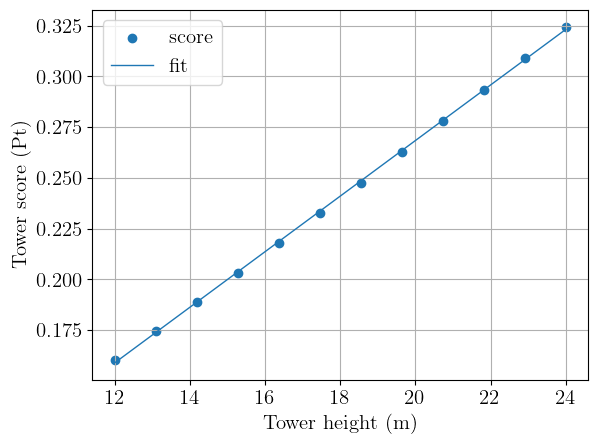

In [129]:
fig, ax = plt.subplots()
ax.set_xlabel('Tower height (m)')
ax.set_ylabel('Tower score (Pt)')
ax.scatter(tow_score_df['mast_length'],tow_score_df['tower_score']+tow_score_cst,linewidth = 1,label="score")
ax.plot(tow_score_df['mast_length'],np.polyval(tow_score_fit,tow_score_df['mast_length'])+tow_score_cst,linewidth = 1,label="fit")
ax.legend()
ax.grid(True)
plt.show()
fig.savefig("figures/tow_score.svg")

In [130]:
#### Battery impacts array #### 
N_d=2
SoC_min=0.5
v_mu=np.arange(3.5,8,0.5)
aep=np.polyval(aep_poly,v_mu)
den_kwh_sc=aep/365*(1-oversizing_factor)*inverter_efficiency*(load_shifting_factor+(1-load_shifting_factor)*battery_efficiency)
bat_cap_kwh_sc=den_kwh_sc*N_d/SoC_min/battery_efficiency
bat_weight_kg_sc=np.polyval(bat_fit,bat_cap_kwh_sc)

bat_score_df = pd.DataFrame({'AEP':aep, 'DEN':den_kwh_sc, 'Cap':bat_cap_kwh_sc, 'Weight':bat_weight_kg_sc, 'Score':np.zeros(len(aep))})



In [131]:
bat_score_df

,AEP,DEN,Cap,Weight,Score
0,437.858762,0.770871,3.854357,126.041750,0.0
1,669.219330,1.178193,5.890964,192.641059,0.0
2,912.319498,1.606182,8.030911,262.619722,0.0
3,1156.443837,2.035975,10.179874,332.893202,0.0
4,1392.577115,2.451699,12.258494,400.866380,0.0
5,1613.404290,2.840476,14.202378,464.433552,0.0
6,1813.310515,3.192420,15.962101,521.978434,0.0
7,1988.381136,3.500640,17.503202,572.374154,0.0
8,2136.401692,3.761238,18.806188,614.983258,0.0


In [132]:
for i,wt in enumerate(bat_score_df['Weight']):
    batteries_exc.as_dict()['amount'] = wt
    batteries_exc.save()
    bat_score_df['Score'][i]=lca_single_score(activities_batteries,methods_EF,NF,WF)
batteries_exc.as_dict()['amount'] =  bat_weight_kg[0]
batteries_exc.save()    

In [133]:
bat_score_df

,AEP,DEN,Cap,Weight,Score
0,437.858762,0.770871,3.854357,126.041750,0.489843
1,669.219330,1.178193,5.890964,192.641059,0.748671
2,912.319498,1.606182,8.030911,262.619722,1.020633
3,1156.443837,2.035975,10.179874,332.893202,1.293741
4,1392.577115,2.451699,12.258494,400.866380,1.557909
5,1613.404290,2.840476,14.202378,464.433552,1.804954
6,1813.310515,3.192420,15.962101,521.978434,2.028593
7,1988.381136,3.500640,17.503202,572.374154,2.224449
8,2136.401692,3.761238,18.806188,614.983258,2.390043


In [134]:
bat_score_df.to_csv("lca_scale/battery_score.csv")


In [135]:
bat_score_df=pd.read_csv("lca_scale/battery_score.csv")
bat_score_fit=np.polyfit(bat_score_df['Weight'],bat_score_df['Score'],1)
bat_score_fit_cap=np.polyfit(bat_score_df['Cap'],bat_score_df['Score'],1)
bat_score_fit

array([ 3.88635482e-03, -4.42978613e-08])

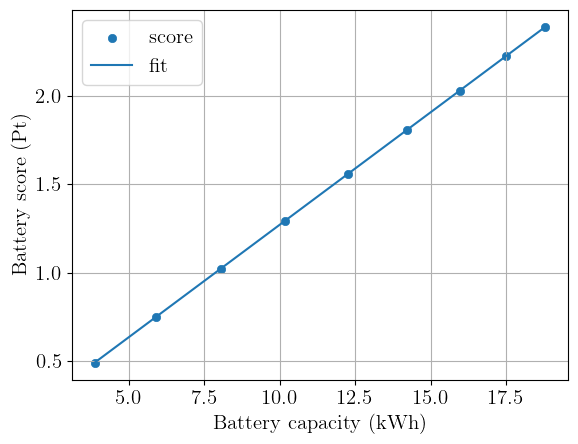

In [136]:
fig, ax = plt.subplots()
ax.set_xlabel('Battery capacity (kWh)')
ax.set_ylabel('Battery score (Pt)')
ax.scatter(bat_score_df['Cap'],bat_score_df['Score'],linewidth = 0.5, label='score')
ax.plot(bat_score_df['Cap'],np.polyval(bat_score_fit_cap,bat_score_df['Cap']),label='fit')
ax.legend()
ax.grid(True)
plt.show()
fig.savefig("figures/bat_score.svg")

## Find score of a grid kwh


In [137]:
act_electricity = [Database('grid').search('grid_electricity')[0]]
act_kwh = [Database('grid').search('market group for electricity, low voltage')[0]]
kwh_key = Database('grid').search('market group for electricity, low voltage')[0].key
kwh_exc = [i for i in act_kwh[0].exchanges() if i['input'] == kwh_key][0]

In [138]:
kwh_score=lca_single_score(act_electricity,methods_EF,NF,WF)

In [139]:
kwh_exc

Exchange: 0.1 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, Europe without Switzerland, None) to 'market group for electricity, low voltage' (kilowatt hour, Europe without Switzerland, None)>

In [140]:
num_kwh=np.arange(1,11,1)

In [141]:
score_kwh=np.zeros([10])
for i,j in enumerate(num_kwh):
    kwh_exc.as_dict()['amount'] = 1/j
    kwh_exc.save()
    score_kwh[i]=lca_single_score(act_kwh,methods_EF,NF,WF)
kwh_exc.as_dict()['amount'] = 1   
kwh_exc.save()

In [142]:
kwh_score_fit=np.polyfit(num_kwh,score_kwh,1)

In [143]:
kwh_score_fit

array([ 4.62102624e-05, -3.21340547e-13])

In [144]:
kwh_score_fit=np.array([ 4.62102624e-05, -3.21340547e-13])

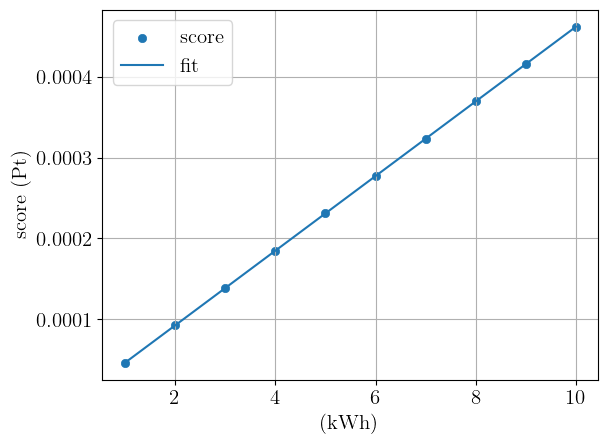

In [145]:
fig, ax = plt.subplots()
ax.set_xlabel('(kWh)')
ax.set_ylabel('score (Pt)')
ax.scatter(num_kwh,score_kwh,linewidth = 0.5, label='score')
ax.plot(num_kwh,np.polyval(kwh_score_fit,num_kwh),label='fit')
ax.legend()
ax.grid(True)
plt.show()

## Height Optimization

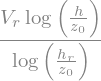

In [146]:
### System modelling in sympy ###
import sympy as sp
# Wind speed
z_0, h_r, V_r, h = sp.symbols('z_0 h_r V_r h',positive=true)
V_h = V_r*sp.log(h/z_0)/sp.log(h_r/z_0)

V_h

In [147]:
# Annual Energy Production
np_aep_poly= np.poly1d(aep_poly)
AEP = sp.Poly(np_aep_poly.coeffs,V_h)
E_p = AEP/sp.sympify(365)

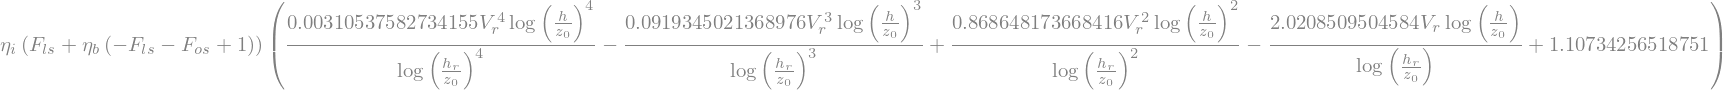

In [148]:
# Daily Energy Needs
eta_b, eta_i, F_s, F_ls, F_os =sp.symbols('eta_b eta_i F_s F_ls F_os',positive=true)
F_s=1-F_ls-F_os
E_n = E_p*eta_i*(F_ls+F_s*eta_b)
E_n


In [149]:
# Lifetime Useful Energy
E_l = sympify(20*365)*E_n

# Battery cap
N_d, SoC_min = sp.symbols('N_d SoC_min',positive=true)
C_bat = N_d*E_n/(SoC_min)

# Battery mass
np_mbat_poly= np.poly1d(bat_fit)
m_bat = sp.Poly(np_mbat_poly.coeffs,C_bat)/1 #/1 forces symbolic expression rather than Poly expression

In [150]:
# Battery impacts
np_Ibat_poly= np.poly1d(bat_score_fit)
I_b = sp.Poly(np_Ibat_poly.coeffs,m_bat)/1

# Tower variable impacts
np_Itow_poly= np.poly1d(tow_score_fit)
I_t = sp.Poly(np_Itow_poly.coeffs,h)/1
I_t

In [151]:
# Fixed impacts
I_f = sp.symbols('I_f',positive=true)
I_f = 0.376032308415008 #cst_score

# Cost function
f_c = (I_f+I_b+I_t)/E_l
I_g = I_f+I_b+I_t


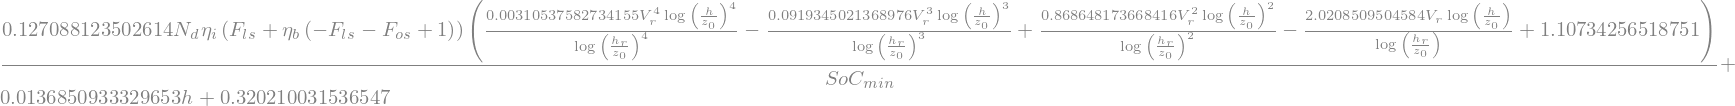

In [152]:
I_g

In [153]:
# for a specific site
#sp.simplify(f_c)


In [154]:
electronics_variables={eta_b:0.8,## battery cycle efficiency
             eta_i:0.9,## inverter efficiency
             F_ls:0.8,## shifted energy
             F_os:0.15,## lost energy
             N_d:2,## days of autonomy
             SoC_min:0.5,## minimum state of charge
            }

f_ce=f_c.subs(electronics_variables)
I_ge=I_g.subs(electronics_variables)
E_ne=E_n.subs(electronics_variables)

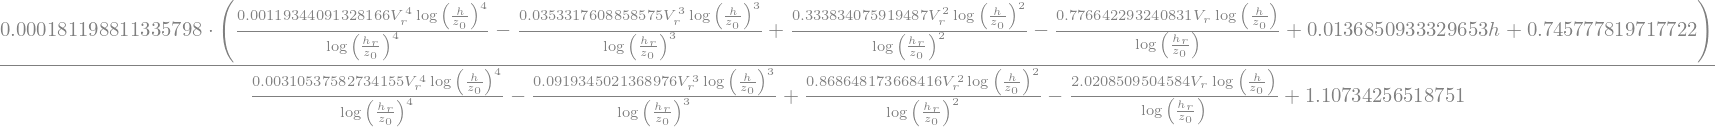

In [155]:
f_ce

In [156]:
#solve(Eq(diff(f_ce.subs(site_specs),h),0)) # this takes too long

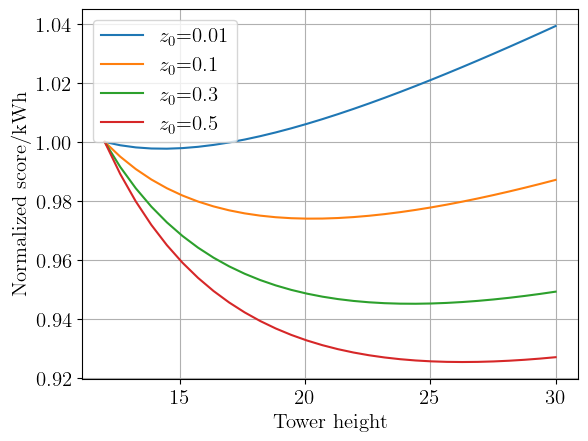

In [157]:
## Plot Cost function in function of tower height for one site
n=30
site_specs_worst={V_r:4,
            h_r:12,
            z_0:0.5
            }
f_cwc=lambdify(h,f_ce.subs(site_specs_worst))
I_wc=f_cwc(12) #mPts # worst case impact scenario
h_array=np.linspace(12,30,n)
z0_array = np.array([0.01, 0.1,0.3, 0.5])
vw_array = np.array([4, 5, 6])
fhz = np.zeros([len(z0_array),n])
fhv = np.zeros([len(vw_array),n])


fig, ax = plt.subplots()
ax.set_xlabel('Tower height')
ax.set_ylabel('Normalized score/kWh')
for i,z in enumerate(z0_array):
    site_specs={V_r:4,
            h_r:12,
            z_0:z
            }
    f_ces=lambdify(h,f_ce.subs(site_specs))
    fhz[i,:]=f_ces(h_array)
    ax.plot(h_array,fhz[i,:]/I_wc,label='$z_0$='+str(z))
ax.legend()
ax.grid(True)
plt.show()    

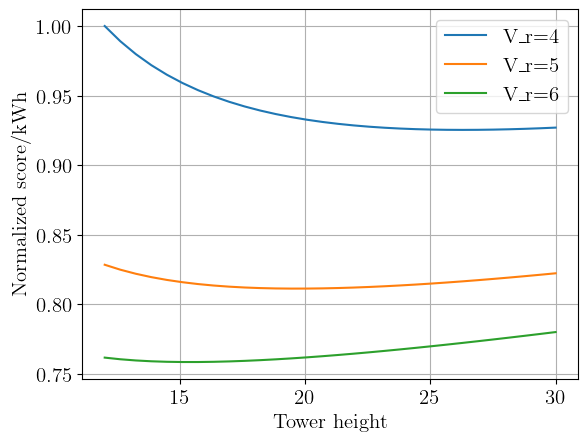

In [158]:
fig, ax = plt.subplots()
ax.set_xlabel('Tower height')
ax.set_ylabel('Normalized score/kWh')
for i,v in enumerate(vw_array):
    site_specs={V_r:v,
            h_r:12,
            z_0:0.5
            }
    f_ces=lambdify(h,f_ce.subs(site_specs))
    fhv[i,:]=f_ces(h_array)
    ax.plot(h_array,fhv[i,:]/I_wc,label='V_r='+str(v))
ax.legend()
ax.grid(True)
plt.show() 

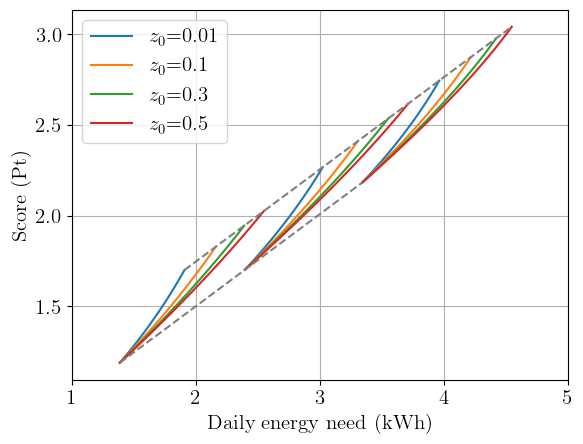

In [159]:
## Plot Impacts = f (DEN)
## for several surface roughness
fig, ax = plt.subplots()
ax.set_xlabel('Daily energy need (kWh)')
ax.set_ylabel('Score (Pt)')
ihz=np.zeros([len(z0_array),n])
color_map = plt.colormaps['tab10']
labels=[0, 0, 0, 0]
bound_max=np.zeros([len(vw_array)*len(z0_array),2])
bound_min=np.zeros([len(vw_array),2])
idx=0
for j,v in enumerate(vw_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        I_ges=lambdify(h,I_ge.subs(site_specs))
        den=lambdify(h,E_ne.subs(site_specs))
        ihz[i,:]=I_ges(h_array)
        labels[i]='$z_0$='+str(z)
        ax.plot(den(h_array),ihz[i,:],label='$z_0$='+str(z), color=color_map(i))
        bound_max[idx,:]=[den(np.max(h_array)),I_ges(np.max(h_array))]
        bound_min[j,:]=[den(np.min(h_array)),I_ges(np.min(h_array))]
        idx+=1
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
p_bmin=np.polyfit(bound_min[:,0],bound_min[:,1],2)
p_bmax=np.polyfit(bound_max[:,0],bound_max[:,1],3)
d_min=np.linspace(bound_min[0,0],bound_min[-1,0],100)
d_max=np.linspace(bound_max[0,0],bound_max[-1,0],100)
ax.plot(d_min,np.polyval(p_bmin,d_min), color='grey',linestyle='dashed')
ax.plot(d_max,np.polyval(p_bmax,d_max), color='grey',linestyle='dashed')
ax.set_xlim(1, 5)
ax.legend(handles[:4], labels)
ax.grid(True)
plt.show()    
fig.savefig("figures/score_den_standalone.svg")

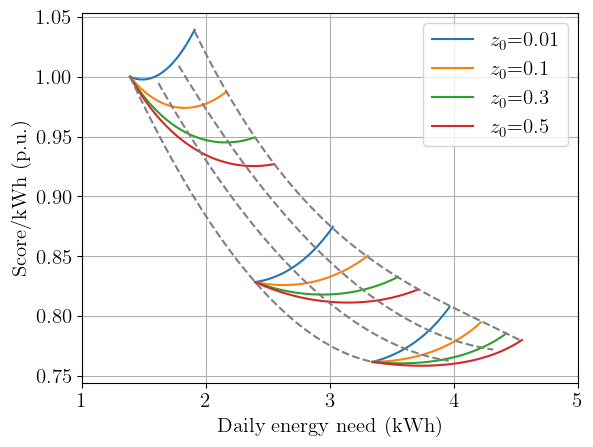

In [160]:
## Plot impacts / kWh = f(DEN)
## Plot Impacts = f (DEN)
## for several surface roughness
fig, ax = plt.subplots()
ax.set_xlabel('Daily energy need (kWh)')
ax.set_ylabel('Score/kWh (p.u.)')
ihz=np.zeros([len(z0_array),n])
color_map = plt.colormaps['tab10']
bound_max=np.zeros([len(vw_array)*len(z0_array),2])
bound_18=np.zeros([len(vw_array)*len(z0_array),2])
bound_24=np.zeros([len(vw_array)*len(z0_array),2])
bound_min=np.zeros([len(vw_array),2])
idx=0
for j,v in enumerate(vw_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        f_ces=lambdify(h,f_ce.subs(site_specs))
        den=lambdify(h,E_ne.subs(site_specs))
        labels[i]='$z_0$='+str(z)
        ax.plot(den(h_array),f_ces(h_array)/I_wc,label='$z_0$='+str(z), color=color_map(i))
        bound_max[idx,:]=[den(np.max(h_array)),f_ces(np.max(h_array))/I_wc]
        bound_24[idx,:]=[den(24),f_ces(24)/I_wc]
        bound_18[idx,:]=[den(18),f_ces(18)/I_wc]
        bound_min[j,:]=[den(np.min(h_array)),f_ces(np.min(h_array))/I_wc]
        idx+=1
p_bmin=np.polyfit(bound_min[:,0],bound_min[:,1],2)
p_b18=np.polyfit(bound_18[:,0],bound_18[:,1],2)
p_b24=np.polyfit(bound_24[:,0],bound_24[:,1],2)
p_bmax=np.polyfit(bound_max[:,0],bound_max[:,1],3)
d_min=np.linspace(bound_min[0,0],bound_min[-1,0],100)
d_18=np.linspace(bound_18[0,0],bound_18[-1,0],100)
d_24=np.linspace(bound_24[0,0],bound_24[-1,0],100)
d_max=np.linspace(bound_max[0,0],bound_max[-1,0],100)
ax.plot(d_min,np.polyval(p_bmin,d_min), color='grey',linestyle='dashed')
ax.plot(d_max,np.polyval(p_bmax,d_max), color='grey',linestyle='dashed')
ax.plot(d_18,np.polyval(p_b18,d_18), color='grey',linestyle='dashed')
ax.plot(d_24,np.polyval(p_b24,d_24), color='grey',linestyle='dashed')
ax.set_xlim(1, 5)  
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
ax.legend(handles[:4], labels)
ax.grid(True)
plt.show()    
fig.savefig("figures/score_norm_den_standalone.svg")

In [161]:
## find optimal height
h_array=np.linspace(12,30,2000)
v_array=np.linspace(4**3,6**3,100)**(1/3) # linear space for cube of wind speed
z_names=["Z001","Z01","Z03","Z05"]
h_opt={"v_r":v_array,"Z001":np.zeros(len(v_array)),"Z01":np.zeros(len(v_array)),"Z03":np.zeros(len(v_array)),"Z05":np.zeros(len(v_array))}
h_opt_df=pd.DataFrame.from_dict(h_opt)
den_opt={"v_r":v_array,"Z001":np.zeros(len(v_array)),"Z01":np.zeros(len(v_array)),"Z03":np.zeros(len(v_array)),"Z05":np.zeros(len(v_array))}
den_opt_df=pd.DataFrame.from_dict(h_opt)
for j,v in enumerate(v_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        f_ces=lambdify(h,f_ce.subs(site_specs))
        h_opt_df.loc[j,z_names[i]]=h_array[np.argmin(f_ces(h_array))]

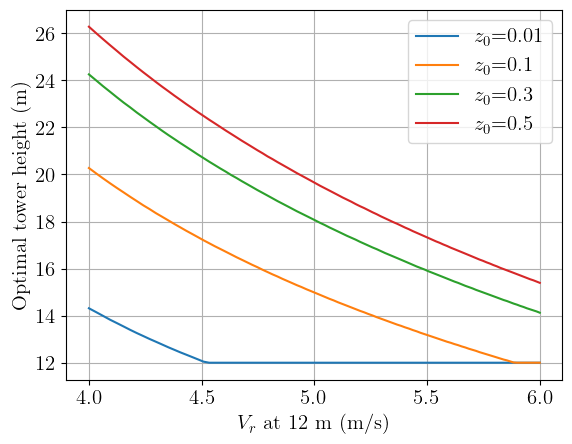

In [162]:
fig, ax = plt.subplots()
ax.set_xlabel('$V_r$ at 12 m (m/s)')
ax.set_ylabel('Optimal tower height (m)')
for i,z in enumerate(z_names):
    ax.plot(h_opt_df["v_r"],h_opt_df[z],label=labels[i])
ax.legend()
ax.grid(True)
plt.show()  
fig.savefig("figures/h_opt_standalone.svg")

In [163]:
## find optimal height
h_array=np.linspace(12,30,2000)
v_array=np.linspace(4**3,6**3,100)**(1/3) # linear space for cube of wind speed
z_names=["Z001","Z01","Z03","Z05"]
h_opt={"v_r":v_array,"Z001":np.zeros(len(v_array)),"Z01":np.zeros(len(v_array)),"Z03":np.zeros(len(v_array)),"Z05":np.zeros(len(v_array))}
h_opt_df=pd.DataFrame.from_dict(h_opt)
den_opt={"v_r":v_array,"Z001":np.zeros(len(v_array)),"Z01":np.zeros(len(v_array)),"Z03":np.zeros(len(v_array)),"Z05":np.zeros(len(v_array))}
den_opt_df=pd.DataFrame.from_dict(h_opt)
for j,v in enumerate(v_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        f_ces=lambdify(h,f_ce.subs(site_specs))
        E_nes=lambdify(h,E_ne.subs(site_specs))
        h_opt_df.loc[j,z_names[i]]=h_array[np.argmin(f_ces(h_array))]
        den_opt_df.loc[j,z_names[i]]=E_nes(h_array[np.argmin(f_ces(h_array))])

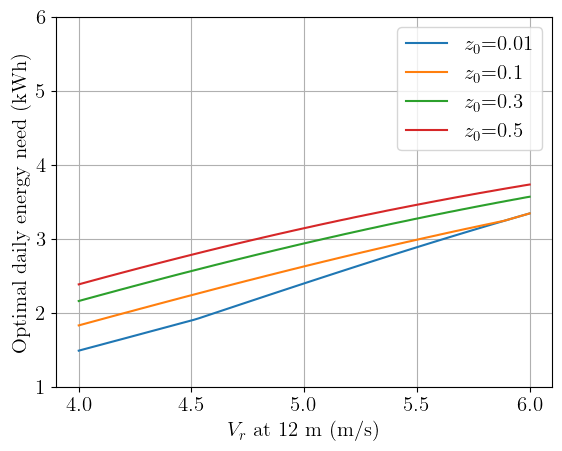

In [164]:
fig, ax = plt.subplots()
ax.set_xlabel('$V_r$ at 12 m (m/s)')
ax.set_ylabel('Optimal daily energy need (kWh)')
for i,z in enumerate(z_names):
    ax.plot(den_opt_df["v_r"],den_opt_df[z],label=labels[i])
ax.legend()
ax.set_ylim(1, 6)  
ax.grid(True)
plt.show()  
fig.savefig("figures/den_opt_standalone.svg")

# Grid tied


In [165]:
E_p = AEP/sp.sympify(365) 
E_n = E_p*eta_i
E_l = E_n*365*20 # lifetime energy need
electronics_variables={
             eta_i:0.9,## inverter efficiency   
            F_ls:0.8
            }

E_ne=(E_n).subs(electronics_variables)

# Energy bought to the grid over lifetime
kwh_grid=(1-F_ls)*E_n*365*20

# Grid energy impacts
np_kwh_poly= np.poly1d(kwh_score_fit)
I_kwh = sp.Poly(np_kwh_poly.coeffs,kwh_grid)/1 #/1 forces symbolic expression rather than Poly expression

I_g = I_f+I_t+I_kwh
f_c = I_g/(E_l)
f_ce = f_c.subs(electronics_variables)
I_ge = I_g.subs(electronics_variables)

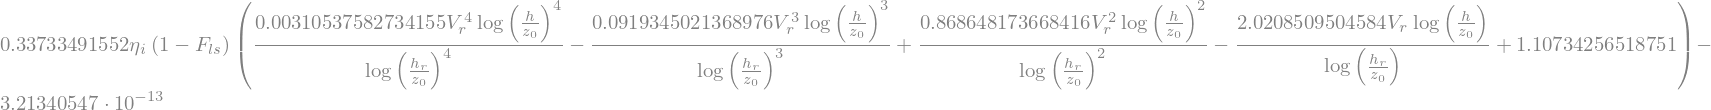

In [166]:
I_kwh

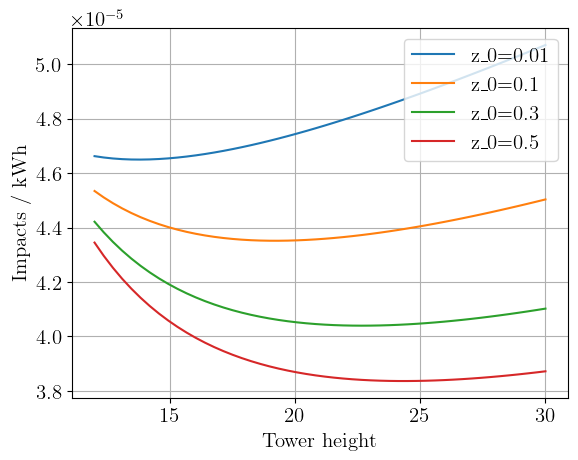

In [167]:
## Plot Cost function in function of tower height for one site
n=50
h_array=np.linspace(12,30,n)


fig, ax = plt.subplots()
ax.set_xlabel('Tower height')
ax.set_ylabel('Impacts / kWh')
for i,z in enumerate(z0_array):
    site_specs={V_r:4,
            h_r:10,
            z_0:z
            }
    f_ces=lambdify(h,f_ce.subs(site_specs))
    ax.plot(h_array,f_ces(h_array),label='z_0='+str(z))
ax.legend()
ax.grid(True)
plt.show()    

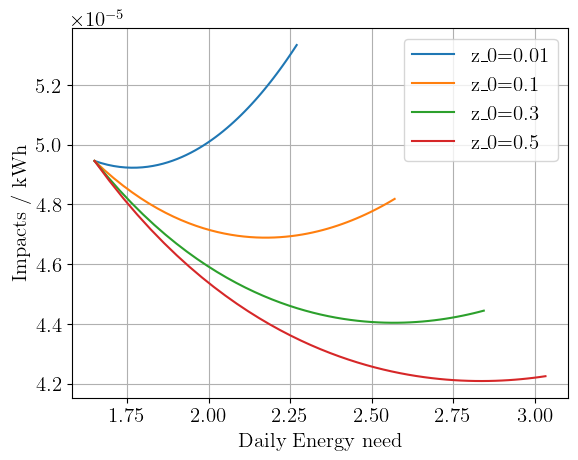

In [168]:
fig, ax = plt.subplots()
ax.set_xlabel('Daily Energy need')
ax.set_ylabel('Impacts / kWh')
for i,z in enumerate(z0_array):
    site_specs={V_r:4,
            h_r:12,
            z_0:z
            }
    f_ces=lambdify(h,f_ce.subs(site_specs))
    e_grid=lambdify(h,E_ne.subs(site_specs))
    ax.plot(e_grid(h_array),f_ces(h_array),label='z_0='+str(z))
ax.legend()
ax.grid(True)
plt.show() 

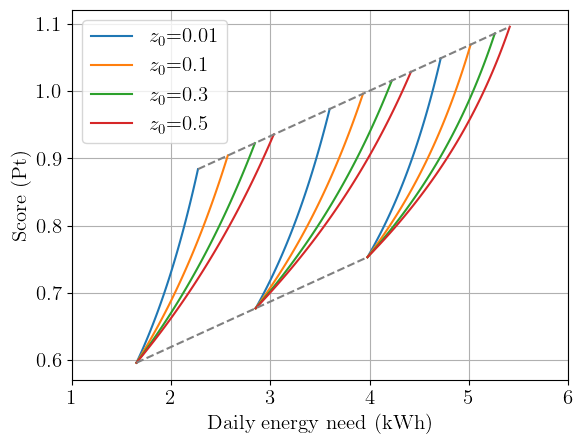

In [169]:
## Plot Impacts = f (DEN)
## for several surface roughness
fig, ax = plt.subplots()
ax.set_xlabel('Daily energy need (kWh)')
ax.set_ylabel('Score (Pt)')
ihz=np.zeros([len(z0_array),n])
color_map = plt.colormaps['tab10']
labels=[0, 0, 0, 0]
bound_max=np.zeros([len(vw_array)*len(z0_array),2])
bound_min=np.zeros([len(vw_array),2])
idx=0
for j,v in enumerate(vw_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        I_ges=lambdify(h,I_ge.subs(site_specs))
        den=lambdify(h,E_ne.subs(site_specs))
        ihz[i,:]=I_ges(h_array)
        labels[i]='$z_0$='+str(z)
        ax.plot(den(h_array),ihz[i,:],label='$z_0$='+str(z), color=color_map(i))
        bound_max[idx,:]=[den(np.max(h_array)),I_ges(np.max(h_array))]
        bound_min[j,:]=[den(np.min(h_array)),I_ges(np.min(h_array))]
        idx+=1
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
p_bmin=np.polyfit(bound_min[:,0],bound_min[:,1],2)
p_bmax=np.polyfit(bound_max[:,0],bound_max[:,1],3)
d_min=np.linspace(bound_min[0,0],bound_min[-1,0],100)
d_max=np.linspace(bound_max[0,0],bound_max[-1,0],100)
ax.plot(d_min,np.polyval(p_bmin,d_min), color='grey',linestyle='dashed')
ax.plot(d_max,np.polyval(p_bmax,d_max), color='grey',linestyle='dashed')
ax.set_xlim(1, 6)
ax.legend(handles[:4], labels)
ax.grid(True)
plt.show()    
fig.savefig("figures/score_den_grid.svg")

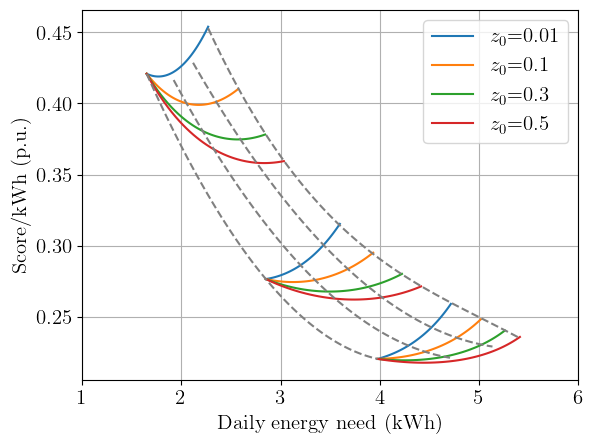

In [170]:
## Plot impacts / kWh = f(DEN)
## Plot Impacts = f (DEN)
## for several surface roughness
fig, ax = plt.subplots()
ax.set_xlabel('Daily energy need (kWh)')
ax.set_ylabel('Score/kWh (p.u.)')
ihz=np.zeros([len(z0_array),n])
color_map = plt.colormaps['tab10']
bound_max=np.zeros([len(vw_array)*len(z0_array),2])
bound_18=np.zeros([len(vw_array)*len(z0_array),2])
bound_24=np.zeros([len(vw_array)*len(z0_array),2])
bound_min=np.zeros([len(vw_array),2])
idx=0
site_specs={V_r:4,
                h_r:12,
                z_0:0.5
                }
I_grid=lambdify(h,f_ce.subs(site_specs))
I_12g=I_grid(12)
for j,v in enumerate(vw_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        f_ces=lambdify(h,f_ce.subs(site_specs))
        den=lambdify(h,E_ne.subs(site_specs))
        labels[i]='$z_0$='+str(z)
        ax.plot(den(h_array),f_ces(h_array)/I_wc,label='$z_0$='+str(z), color=color_map(i))
        bound_max[idx,:]=[den(np.max(h_array)),f_ces(np.max(h_array))/I_wc]
        bound_24[idx,:]=[den(24),f_ces(24)/I_wc]
        bound_18[idx,:]=[den(18),f_ces(18)/I_wc]
        bound_min[j,:]=[den(np.min(h_array)),f_ces(np.min(h_array))/I_wc]
        idx+=1
p_bmin=np.polyfit(bound_min[:,0],bound_min[:,1],2)
p_b18=np.polyfit(bound_18[:,0],bound_18[:,1],2)
p_b24=np.polyfit(bound_24[:,0],bound_24[:,1],2)
p_bmax=np.polyfit(bound_max[:,0],bound_max[:,1],3)
d_min=np.linspace(bound_min[0,0],bound_min[-1,0],100)
d_18=np.linspace(bound_18[0,0],bound_18[-1,0],100)
d_24=np.linspace(bound_24[0,0],bound_24[-1,0],100)
d_max=np.linspace(bound_max[0,0],bound_max[-1,0],100)
ax.plot(d_min,np.polyval(p_bmin,d_min), color='grey',linestyle='dashed')
ax.plot(d_max,np.polyval(p_bmax,d_max), color='grey',linestyle='dashed')
ax.plot(d_18,np.polyval(p_b18,d_18), color='grey',linestyle='dashed')
ax.plot(d_24,np.polyval(p_b24,d_24), color='grey',linestyle='dashed')
ax.set_xlim(1, 6)  
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
ax.legend(handles[:4], labels)
ax.grid(True)
plt.show()    
fig.savefig("figures/score_norm_den_grid.svg")

In [171]:
## find optimal height
h_array=np.linspace(12,30,2000)
v_array=np.linspace(4**3,6**3,100)**(1/3) # linear space for cube of wind speed
z_names=["Z001","Z01","Z03","Z05"]
h_opt={"v_r":v_array,"Z001":np.zeros(len(v_array)),"Z01":np.zeros(len(v_array)),"Z03":np.zeros(len(v_array)),"Z05":np.zeros(len(v_array))}
h_opt_df=pd.DataFrame.from_dict(h_opt)
for j,v in enumerate(v_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        f_ces=lambdify(h,f_ce.subs(site_specs))
        h_opt_df.loc[j,z_names[i]]=h_array[np.argmin(f_ces(h_array))]

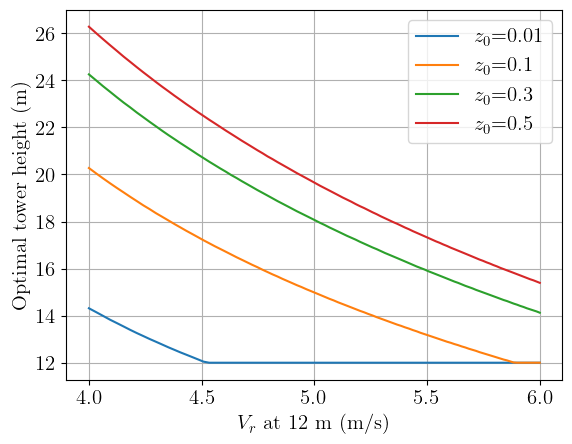

In [172]:
fig, ax = plt.subplots()
ax.set_xlabel('$V_r$ at 12 m (m/s)')
ax.set_ylabel('Optimal tower height (m)')
for i,z in enumerate(z_names):
    ax.plot(h_opt_df["v_r"],h_opt_df[z],label=labels[i])
ax.legend()
ax.grid(True)
plt.show()  
fig.savefig("figures/h_opt_grid.svg")

In [173]:
## find optimal height
h_array=np.linspace(12,30,2000)
v_array=np.linspace(4**3,6**3,100)**(1/3) # linear space for cube of wind speed
z_names=["Z001","Z01","Z03","Z05"]
h_opt={"v_r":v_array,"Z001":np.zeros(len(v_array)),"Z01":np.zeros(len(v_array)),"Z03":np.zeros(len(v_array)),"Z05":np.zeros(len(v_array))}
h_opt_df=pd.DataFrame.from_dict(h_opt)
den_opt={"v_r":v_array,"Z001":np.zeros(len(v_array)),"Z01":np.zeros(len(v_array)),"Z03":np.zeros(len(v_array)),"Z05":np.zeros(len(v_array))}
den_opt_df=pd.DataFrame.from_dict(h_opt)
for j,v in enumerate(v_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:12,
                z_0:z
                }
        f_ces=lambdify(h,f_ce.subs(site_specs))
        E_nes=lambdify(h,E_ne.subs(site_specs))
        h_opt_df.loc[j,z_names[i]]=h_array[np.argmin(f_ces(h_array))]
        den_opt_df.loc[j,z_names[i]]=E_nes(h_array[np.argmin(f_ces(h_array))])

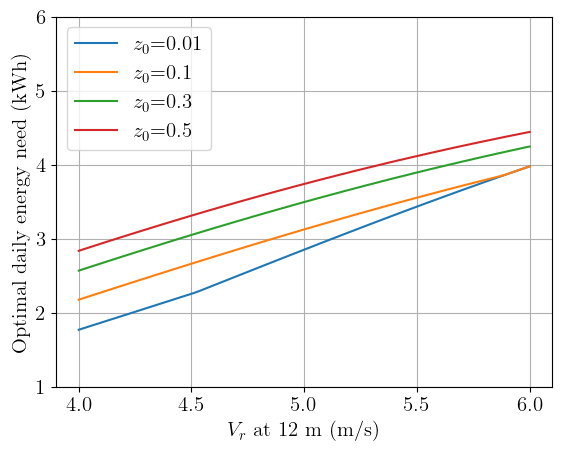

In [174]:
fig, ax = plt.subplots()
ax.set_xlabel('$V_r$ at 12 m (m/s)')
ax.set_ylabel('Optimal daily energy need (kWh)')
for i,z in enumerate(z_names):
    ax.plot(den_opt_df["v_r"],den_opt_df[z],label=labels[i])
ax.legend()
ax.set_ylim(1, 6)  
ax.grid(True)
plt.show()  
fig.savefig("figures/den_opt_grid.svg")

## Map data

In [175]:
z0_df = pd.read_csv("data/z_values.csv", delimiter=';', decimal=',')

In [176]:
z0_df

,Z₀,z
0,0.000,0.0015
1,0.003,0.0040
2,0.005,0.0075
3,0.010,0.0200
4,0.030,0.0400
5,0.050,0.0750
6,0.100,0.1500
7,0.200,0.2500
8,0.300,0.4500
9,0.600,0.7000


In [177]:
z0_array=z0_df['Z₀']

In [178]:
z0_array.pop(0)

In [179]:
for i,z in enumerate(z0_array):
    print(i)
    print(z)

0
0.003
1
0.005
2
0.01
3
0.03
4
0.05
5
0.1
6
0.2
7
0.3
8
0.6
9
0.8
10
1.0
11
1.2
12
1.5


In [180]:
## find optimal height
h_array=np.linspace(12,30,200)
v_array=np.linspace(2.5**3,8**3,500)**(1/3) # linear space for cube of wind speed
h_opt_dict={"z=" + str(z):np.zeros([len(v_array)])  for i,z in enumerate(z0_array)}
h_opt_df=pd.DataFrame.from_dict(h_opt_dict)
den_opt_grid_df=h_opt_df.copy(deep=True)
for j,v in enumerate(v_array):
    for i,z in enumerate(z0_array):
        site_specs={V_r:v,
                h_r:10,
                z_0:z
                }
        f_ces=lambdify(h,f_ce.subs(site_specs))
        E_nes=lambdify(h,E_ne.subs(site_specs))
        h_opt_df.loc[j,"z=" + str(z)]=h_array[np.argmin(f_ces(h_array))]
        den_opt_grid_df.loc[j,"z=" + str(z)]=E_nes(h_array[np.argmin(f_ces(h_array))])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


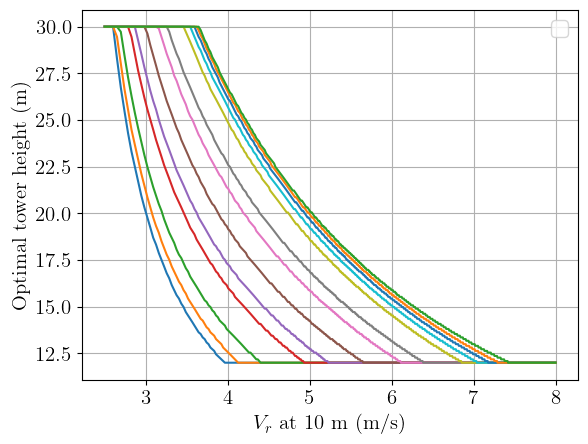

In [181]:
fig, ax = plt.subplots()
ax.set_xlabel('$V_r$ at 10 m (m/s)')
ax.set_ylabel('Optimal tower height (m)')
for i,z in enumerate(z0_array):
    ax.plot(v_array,h_opt_df["z=" + str(z)])
ax.legend()
ax.grid(True)
plt.show()  

In [182]:
h_opt_df.loc[:,"Vr"]=v_array

In [183]:
h_opt_df

,z=0.003,z=0.005,z=0.01,z=0.03,z=0.05,z=0.1,z=0.2,z=0.3,z=0.6,z=0.8,z=1.0,z=1.2,z=1.5,Vr
0,30.000000,30.000000,30.000000,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,2.500000
1,30.000000,30.000000,30.000000,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,2.551965
2,30.000000,30.000000,30.000000,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,2.601896
3,28.281407,29.457286,30.000000,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,2.649981
4,26.743719,28.010050,29.728643,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,2.696381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,12.000000,12.000000,12.000000,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,7.979222
496,12.000000,12.000000,12.000000,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,7.984427
497,12.000000,12.000000,12.000000,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,7.989625
498,12.000000,12.000000,12.000000,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,7.994816


In [184]:
h_opt_df.to_csv("h_opt_map.csv")

In [185]:
den_opt_grid_df

,z=0.003,z=0.005,z=0.01,z=0.03,z=0.05,z=0.1,z=0.2,z=0.3,z=0.6,z=0.8,z=1.0,z=1.2,z=1.5
0,0.422152,0.442176,0.474528,0.543308,0.586069,0.661033,0.765914,0.848916,1.053753,1.176018,1.294344,1.411516,1.588652
1,0.474519,0.495526,0.529443,0.601461,0.646178,0.724472,0.833817,0.920203,1.132886,1.259517,1.381859,1.502815,1.685320
2,0.526170,0.548120,0.583537,0.658655,0.705241,0.786714,0.900311,0.989913,1.210024,1.340771,1.466887,1.591384,1.778888
3,0.558990,0.593899,0.636808,0.714897,0.763273,0.847784,0.965436,1.058099,1.285253,1.419885,1.549549,1.677363,1.869527
4,0.590802,0.627481,0.685769,0.770199,0.820290,0.907709,1.029234,1.124812,1.358650,1.496953,1.629957,1.760883,1.957393
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5.645209,5.651053,5.660289,5.679145,5.690383,5.709281,5.734204,5.752833,5.795340,5.818721,5.840147,5.860329,5.889114
496,5.647794,5.653625,5.662841,5.681656,5.692869,5.711724,5.736589,5.755173,5.797574,5.820895,5.842263,5.862391,5.891096
497,5.650368,5.656187,5.665383,5.684157,5.695344,5.714156,5.738963,5.757503,5.799798,5.823058,5.844371,5.864443,5.893068
498,5.652932,5.658738,5.667914,5.686647,5.697809,5.716578,5.741327,5.759822,5.802013,5.825212,5.846468,5.866486,5.895031


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


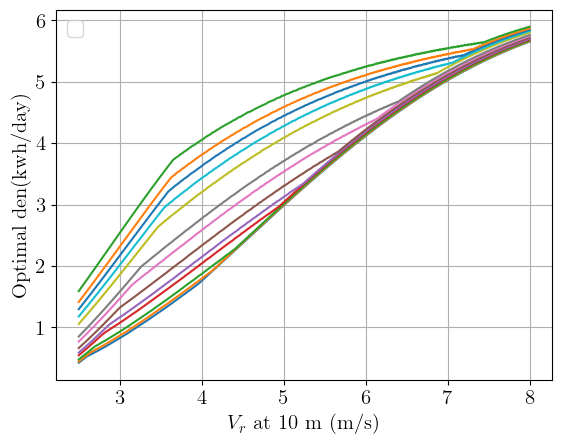

In [186]:
fig, ax = plt.subplots()
ax.set_xlabel('$V_r$ at 10 m (m/s)')
ax.set_ylabel('Optimal den(kwh/day)')
for i,z in enumerate(z0_array):
    ax.plot(v_array,den_opt_grid_df["z=" + str(z)])
ax.legend()
ax.grid(True)
plt.show()  